In [64]:
import json 
import numpy as np
import matplotlib.pyplot as plt
from pypots.optim import Adam
from pypots.imputation import CSDI, BRITS
from pypots.utils.random import set_random_seed
from pypots.utils.metrics import calc_mae
import pickle
import sys
sys.path.append("../../../Interpolation/Imputation_Algs/cdrec")
from cdrec.python.recovery import centroid_recovery as CDrec
set_random_seed(1234)

2024-10-21 10:52:00 [INFO]: Have set the random seed as 1234 for numpy and pytorch.


In [19]:
# check that GPU acceleration is enabled
import torch
torch.cuda.device_count()
print(f"GPU: {torch.cuda.get_device_name()}")
print(f"CUDA ENABLED: {torch.cuda.is_available()}")

GPU: NVIDIA GeForce GTX 1070
CUDA ENABLED: True


Load the original ECG200 train/test split:

In [20]:
train_f = np.loadtxt("ECG200_TRAIN.txt")
test_f = np.loadtxt("ECG200_TEST.txt")
X_train = train_f[:, 1:]
y_train = train_f[:, 0]
X_test = test_f[:, 1:]
y_test = test_f[:, 0]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(100, 96)
(100,)
(100, 96)
(100,)


In [21]:
# reshape data for imputation model
X_train_original = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_original =  X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_train_original = y_train
y_test_original = y_test
print(X_train_original.shape)
print(X_test_original.shape)

(100, 96, 1)
(100, 96, 1)


Combine the train and test splits for resampling

In [22]:
Xs = np.vstack([X_train_original, X_test_original])
print(Xs.shape)
ys = np.concatenate([y_train_original, y_test_original])
print(ys.shape)

(200, 96, 1)
(200,)


Load the resample fold indices:

In [23]:
with open("resample_folds_python_idx.json", "r") as f:
    resample_fold_idxs_f = json.load(f)
resample_fold_idxs = {int(k): v for k, v in resample_fold_idxs_f.items()}
print(resample_fold_idxs.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])


Check that the first fold corresponds to the original train/test split

In [24]:
X_train_f1 = Xs[resample_fold_idxs[0]["train"]]
X_test_f1 = Xs[resample_fold_idxs[0]["test"]]
y_train_f1 = ys[resample_fold_idxs[0]["train"]]
y_test_f1 = ys[resample_fold_idxs[0]["test"]]

print(X_train_f1.shape)
print(X_test_f1.shape)
print(y_train_f1.shape)
print(y_test_f1.shape)

print(np.all(np.equal(X_train_f1, X_train_original)))
print(np.all(np.equal(y_train_f1, y_train_original)))
print(np.all(np.equal(X_test_f1, X_test_original)))
print(np.all(np.equal(y_test_f1, y_test_original)))

(100, 96, 1)
(100, 96, 1)
(100,)
(100,)
True
True
True
True


Load the imputation window idxs:

In [25]:
with open("windows_python_idx.json", "r") as f:
    window_idxs_f = json.load(f)
window_idxs = {int(float(k)*100): v for k, v in window_idxs_f.items()}
print(window_idxs.keys())

dict_keys([5, 15, 25, 35, 45, 55, 65, 75, 85, 95])


Define a function to evaluate CSDI across folds and window idxs

In [9]:
def evaluate_folds_csdi(Xs, ys, fold_idxs, window_idxs, model):
    fold_scores = dict()
    for fold in range(0, len(fold_idxs)):
        print(f"Evaluating fold {fold}/{len(fold_idxs)-1}...")
        # make the splits
        X_train_fold = Xs[fold_idxs[fold]["train"]]
        y_train_fold = ys[fold_idxs[fold]["train"]]
        X_test_fold = Xs[fold_idxs[fold]["test"]]
        y_test_fold = ys[fold_idxs[fold]["test"]]
        # check class distributions
        counts_tr = np.unique(y_train_fold, return_counts=True)[1]
        print(f"Training class distribution: {counts_tr/np.sum(counts_tr)}")
        counts_te = np.unique(y_test_fold, return_counts=True)[1]
        print(f"Testing class distribution: {counts_te/np.sum(counts_te)}")
        print(f"Training CSDI on fold {fold}...")
        model.fit(train_set={'X':X_train_fold})
        print("Finished training!")
        # loop over % missing
        percent_missing_score = dict()
        for pm in window_idxs:
            print(f"Imputing {pm}% missing data over {len(window_idxs[pm])} windows...")
            per_window_scores = dict()
            for (idx, widx) in enumerate(window_idxs[pm]):
                X_test_corrupted = X_test_fold.copy()
                X_test_corrupted[:, widx] = np.nan
                mask = np.isnan(X_test_corrupted) # mask ensures only misisng values are imputed
                csdi_imputed = model.impute(test_set={'X': X_test_corrupted}).squeeze(axis=1)
                errs = [calc_mae(csdi_imputed[i], X_test_fold[i], mask[i]) for i in range(0, X_test_fold.shape[0])] # get individual errors for uncertainty quantification
                per_window_scores[idx] = errs
            percent_missing_score[pm] = per_window_scores
        fold_scores[fold] = percent_missing_score
    return fold_scores

Define CSDI model

In [10]:
csdi = CSDI(
    n_steps=len(X_test_original[0]),
    n_features=1, # univariate time series, so num features is equal to one
    n_layers=6,
    n_heads=2,
    n_channels=128,
    d_time_embedding=64,
    d_feature_embedding=32,
    d_diffusion_embedding=128,
    target_strategy="random",
    n_diffusion_steps=50,
    batch_size=32,
    epochs=100,
    patience=None,
    optimizer=Adam(lr=1e-3),
    num_workers=0,
    device=None,
    model_saving_strategy=None
)

2024-10-20 20:59:44 [INFO]: No given device, using default device: cuda
2024-10-20 20:59:44 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
c:\Users\smoor\miniconda3\envs\pypots\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
2024-10-20 20:59:44 [INFO]: CSDI initialized with the given hyperparameters, the number of trainable parameters: 1,693,601


Evaluate CSDI

In [12]:
fold_scores_csdi = evaluate_folds_csdi(Xs, ys, resample_fold_idxs, window_idxs,csdi)

2024-10-20 21:00:12 [INFO]: Epoch 001 - training loss: 0.1609


Evaluating fold 0/29...
Training class distribution: [0.31 0.69]
Testing class distribution: [0.36 0.64]
Training CSDI on fold 0...


2024-10-20 21:00:12 [INFO]: Epoch 002 - training loss: 0.2104
2024-10-20 21:00:12 [INFO]: Epoch 003 - training loss: 0.2259
2024-10-20 21:00:12 [INFO]: Epoch 004 - training loss: 0.3225
2024-10-20 21:00:12 [INFO]: Epoch 005 - training loss: 0.2007
2024-10-20 21:00:12 [INFO]: Epoch 006 - training loss: 0.2876
2024-10-20 21:00:13 [INFO]: Epoch 007 - training loss: 0.1745
2024-10-20 21:00:13 [INFO]: Epoch 008 - training loss: 0.2211
2024-10-20 21:00:13 [INFO]: Epoch 009 - training loss: 0.1848
2024-10-20 21:00:13 [INFO]: Epoch 010 - training loss: 0.1543
2024-10-20 21:00:13 [INFO]: Epoch 011 - training loss: 0.2865
2024-10-20 21:00:13 [INFO]: Epoch 012 - training loss: 0.1915
2024-10-20 21:00:14 [INFO]: Epoch 013 - training loss: 0.1835
2024-10-20 21:00:14 [INFO]: Epoch 014 - training loss: 0.1992
2024-10-20 21:00:14 [INFO]: Epoch 015 - training loss: 0.1615
2024-10-20 21:00:14 [INFO]: Epoch 016 - training loss: 0.1701
2024-10-20 21:00:14 [INFO]: Epoch 017 - training loss: 0.1846
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 21:04:15 [INFO]: Epoch 001 - training loss: 0.1595


Evaluating fold 1/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training CSDI on fold 1...


2024-10-20 21:04:15 [INFO]: Epoch 002 - training loss: 0.2603
2024-10-20 21:04:15 [INFO]: Epoch 003 - training loss: 0.2220
2024-10-20 21:04:15 [INFO]: Epoch 004 - training loss: 0.2677
2024-10-20 21:04:15 [INFO]: Epoch 005 - training loss: 0.1760
2024-10-20 21:04:15 [INFO]: Epoch 006 - training loss: 0.2579
2024-10-20 21:04:15 [INFO]: Epoch 007 - training loss: 0.1384
2024-10-20 21:04:16 [INFO]: Epoch 008 - training loss: 0.2309
2024-10-20 21:04:16 [INFO]: Epoch 009 - training loss: 0.1610
2024-10-20 21:04:16 [INFO]: Epoch 010 - training loss: 0.1623
2024-10-20 21:04:16 [INFO]: Epoch 011 - training loss: 0.2104
2024-10-20 21:04:16 [INFO]: Epoch 012 - training loss: 0.2072
2024-10-20 21:04:16 [INFO]: Epoch 013 - training loss: 0.2379
2024-10-20 21:04:17 [INFO]: Epoch 014 - training loss: 0.2609
2024-10-20 21:04:17 [INFO]: Epoch 015 - training loss: 0.1571
2024-10-20 21:04:17 [INFO]: Epoch 016 - training loss: 0.2452
2024-10-20 21:04:17 [INFO]: Epoch 017 - training loss: 0.2982
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 21:08:19 [INFO]: Epoch 001 - training loss: 0.2883


Evaluating fold 2/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training CSDI on fold 2...


2024-10-20 21:08:19 [INFO]: Epoch 002 - training loss: 0.2717
2024-10-20 21:08:19 [INFO]: Epoch 003 - training loss: 0.2388
2024-10-20 21:08:19 [INFO]: Epoch 004 - training loss: 0.2221
2024-10-20 21:08:19 [INFO]: Epoch 005 - training loss: 0.1722
2024-10-20 21:08:19 [INFO]: Epoch 006 - training loss: 0.3317
2024-10-20 21:08:19 [INFO]: Epoch 007 - training loss: 0.1438
2024-10-20 21:08:20 [INFO]: Epoch 008 - training loss: 0.2268
2024-10-20 21:08:20 [INFO]: Epoch 009 - training loss: 0.1312
2024-10-20 21:08:20 [INFO]: Epoch 010 - training loss: 0.2458
2024-10-20 21:08:20 [INFO]: Epoch 011 - training loss: 0.1727
2024-10-20 21:08:20 [INFO]: Epoch 012 - training loss: 0.1653
2024-10-20 21:08:20 [INFO]: Epoch 013 - training loss: 0.2252
2024-10-20 21:08:21 [INFO]: Epoch 014 - training loss: 0.2084
2024-10-20 21:08:21 [INFO]: Epoch 015 - training loss: 0.1318
2024-10-20 21:08:21 [INFO]: Epoch 016 - training loss: 0.2313
2024-10-20 21:08:21 [INFO]: Epoch 017 - training loss: 0.2088
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 21:12:22 [INFO]: Epoch 001 - training loss: 0.2071


Evaluating fold 3/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training CSDI on fold 3...


2024-10-20 21:12:22 [INFO]: Epoch 002 - training loss: 0.1538
2024-10-20 21:12:22 [INFO]: Epoch 003 - training loss: 0.2040
2024-10-20 21:12:22 [INFO]: Epoch 004 - training loss: 0.2706
2024-10-20 21:12:22 [INFO]: Epoch 005 - training loss: 0.2321
2024-10-20 21:12:23 [INFO]: Epoch 006 - training loss: 0.1410
2024-10-20 21:12:23 [INFO]: Epoch 007 - training loss: 0.2554
2024-10-20 21:12:23 [INFO]: Epoch 008 - training loss: 0.1603
2024-10-20 21:12:23 [INFO]: Epoch 009 - training loss: 0.0977
2024-10-20 21:12:23 [INFO]: Epoch 010 - training loss: 0.1363
2024-10-20 21:12:23 [INFO]: Epoch 011 - training loss: 0.1481
2024-10-20 21:12:24 [INFO]: Epoch 012 - training loss: 0.1827
2024-10-20 21:12:24 [INFO]: Epoch 013 - training loss: 0.0939
2024-10-20 21:12:24 [INFO]: Epoch 014 - training loss: 0.1526
2024-10-20 21:12:24 [INFO]: Epoch 015 - training loss: 0.2443
2024-10-20 21:12:24 [INFO]: Epoch 016 - training loss: 0.1676
2024-10-20 21:12:24 [INFO]: Epoch 017 - training loss: 0.2226
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 21:16:25 [INFO]: Epoch 001 - training loss: 0.2712


Evaluating fold 4/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training CSDI on fold 4...


2024-10-20 21:16:25 [INFO]: Epoch 002 - training loss: 0.2041
2024-10-20 21:16:25 [INFO]: Epoch 003 - training loss: 0.1128
2024-10-20 21:16:25 [INFO]: Epoch 004 - training loss: 0.2400
2024-10-20 21:16:26 [INFO]: Epoch 005 - training loss: 0.2355
2024-10-20 21:16:26 [INFO]: Epoch 006 - training loss: 0.1542
2024-10-20 21:16:26 [INFO]: Epoch 007 - training loss: 0.2581
2024-10-20 21:16:26 [INFO]: Epoch 008 - training loss: 0.2118
2024-10-20 21:16:26 [INFO]: Epoch 009 - training loss: 0.1883
2024-10-20 21:16:26 [INFO]: Epoch 010 - training loss: 0.1609
2024-10-20 21:16:27 [INFO]: Epoch 011 - training loss: 0.2833
2024-10-20 21:16:27 [INFO]: Epoch 012 - training loss: 0.2256
2024-10-20 21:16:27 [INFO]: Epoch 013 - training loss: 0.1001
2024-10-20 21:16:27 [INFO]: Epoch 014 - training loss: 0.1539
2024-10-20 21:16:27 [INFO]: Epoch 015 - training loss: 0.1437
2024-10-20 21:16:27 [INFO]: Epoch 016 - training loss: 0.1824
2024-10-20 21:16:27 [INFO]: Epoch 017 - training loss: 0.2157
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 21:20:29 [INFO]: Epoch 001 - training loss: 0.2835


Evaluating fold 5/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training CSDI on fold 5...


2024-10-20 21:20:29 [INFO]: Epoch 002 - training loss: 0.1646
2024-10-20 21:20:29 [INFO]: Epoch 003 - training loss: 0.2665
2024-10-20 21:20:29 [INFO]: Epoch 004 - training loss: 0.1316
2024-10-20 21:20:29 [INFO]: Epoch 005 - training loss: 0.1354
2024-10-20 21:20:29 [INFO]: Epoch 006 - training loss: 0.1848
2024-10-20 21:20:29 [INFO]: Epoch 007 - training loss: 0.2518
2024-10-20 21:20:30 [INFO]: Epoch 008 - training loss: 0.1776
2024-10-20 21:20:30 [INFO]: Epoch 009 - training loss: 0.1838
2024-10-20 21:20:30 [INFO]: Epoch 010 - training loss: 0.2839
2024-10-20 21:20:30 [INFO]: Epoch 011 - training loss: 0.1246
2024-10-20 21:20:30 [INFO]: Epoch 012 - training loss: 0.2765
2024-10-20 21:20:30 [INFO]: Epoch 013 - training loss: 0.2054
2024-10-20 21:20:31 [INFO]: Epoch 014 - training loss: 0.1649
2024-10-20 21:20:31 [INFO]: Epoch 015 - training loss: 0.1343
2024-10-20 21:20:31 [INFO]: Epoch 016 - training loss: 0.1517
2024-10-20 21:20:31 [INFO]: Epoch 017 - training loss: 0.2937
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 21:24:33 [INFO]: Epoch 001 - training loss: 0.2319


Evaluating fold 6/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training CSDI on fold 6...


2024-10-20 21:24:33 [INFO]: Epoch 002 - training loss: 0.1316
2024-10-20 21:24:34 [INFO]: Epoch 003 - training loss: 0.1655
2024-10-20 21:24:34 [INFO]: Epoch 004 - training loss: 0.1964
2024-10-20 21:24:34 [INFO]: Epoch 005 - training loss: 0.1620
2024-10-20 21:24:34 [INFO]: Epoch 006 - training loss: 0.2011
2024-10-20 21:24:34 [INFO]: Epoch 007 - training loss: 0.2154
2024-10-20 21:24:34 [INFO]: Epoch 008 - training loss: 0.1783
2024-10-20 21:24:34 [INFO]: Epoch 009 - training loss: 0.4012
2024-10-20 21:24:35 [INFO]: Epoch 010 - training loss: 0.1421
2024-10-20 21:24:35 [INFO]: Epoch 011 - training loss: 0.1248
2024-10-20 21:24:35 [INFO]: Epoch 012 - training loss: 0.1695
2024-10-20 21:24:35 [INFO]: Epoch 013 - training loss: 0.1352
2024-10-20 21:24:35 [INFO]: Epoch 014 - training loss: 0.1922
2024-10-20 21:24:35 [INFO]: Epoch 015 - training loss: 0.1589
2024-10-20 21:24:35 [INFO]: Epoch 016 - training loss: 0.1300
2024-10-20 21:24:36 [INFO]: Epoch 017 - training loss: 0.2157
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 21:28:37 [INFO]: Epoch 001 - training loss: 0.1935


Evaluating fold 7/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training CSDI on fold 7...


2024-10-20 21:28:37 [INFO]: Epoch 002 - training loss: 0.1463
2024-10-20 21:28:37 [INFO]: Epoch 003 - training loss: 0.1773
2024-10-20 21:28:37 [INFO]: Epoch 004 - training loss: 0.1617
2024-10-20 21:28:38 [INFO]: Epoch 005 - training loss: 0.2548
2024-10-20 21:28:38 [INFO]: Epoch 006 - training loss: 0.2121
2024-10-20 21:28:38 [INFO]: Epoch 007 - training loss: 0.2575
2024-10-20 21:28:38 [INFO]: Epoch 008 - training loss: 0.2279
2024-10-20 21:28:38 [INFO]: Epoch 009 - training loss: 0.1226
2024-10-20 21:28:38 [INFO]: Epoch 010 - training loss: 0.1922
2024-10-20 21:28:38 [INFO]: Epoch 011 - training loss: 0.1428
2024-10-20 21:28:39 [INFO]: Epoch 012 - training loss: 0.1667
2024-10-20 21:28:39 [INFO]: Epoch 013 - training loss: 0.1581
2024-10-20 21:28:39 [INFO]: Epoch 014 - training loss: 0.1356
2024-10-20 21:28:39 [INFO]: Epoch 015 - training loss: 0.2651
2024-10-20 21:28:39 [INFO]: Epoch 016 - training loss: 0.1767
2024-10-20 21:28:39 [INFO]: Epoch 017 - training loss: 0.2526
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 21:32:41 [INFO]: Epoch 001 - training loss: 0.3164


Evaluating fold 8/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training CSDI on fold 8...


2024-10-20 21:32:41 [INFO]: Epoch 002 - training loss: 0.1745
2024-10-20 21:32:41 [INFO]: Epoch 003 - training loss: 0.3335
2024-10-20 21:32:41 [INFO]: Epoch 004 - training loss: 0.1915
2024-10-20 21:32:41 [INFO]: Epoch 005 - training loss: 0.1987
2024-10-20 21:32:41 [INFO]: Epoch 006 - training loss: 0.2245
2024-10-20 21:32:41 [INFO]: Epoch 007 - training loss: 0.1492
2024-10-20 21:32:42 [INFO]: Epoch 008 - training loss: 0.1692
2024-10-20 21:32:42 [INFO]: Epoch 009 - training loss: 0.2182
2024-10-20 21:32:42 [INFO]: Epoch 010 - training loss: 0.1492
2024-10-20 21:32:42 [INFO]: Epoch 011 - training loss: 0.2212
2024-10-20 21:32:42 [INFO]: Epoch 012 - training loss: 0.1885
2024-10-20 21:32:42 [INFO]: Epoch 013 - training loss: 0.0942
2024-10-20 21:32:43 [INFO]: Epoch 014 - training loss: 0.1368
2024-10-20 21:32:43 [INFO]: Epoch 015 - training loss: 0.2711
2024-10-20 21:32:43 [INFO]: Epoch 016 - training loss: 0.1944
2024-10-20 21:32:43 [INFO]: Epoch 017 - training loss: 0.1650
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 21:36:44 [INFO]: Epoch 001 - training loss: 0.2107


Evaluating fold 9/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training CSDI on fold 9...


2024-10-20 21:36:44 [INFO]: Epoch 002 - training loss: 0.1429
2024-10-20 21:36:45 [INFO]: Epoch 003 - training loss: 0.1432
2024-10-20 21:36:45 [INFO]: Epoch 004 - training loss: 0.1899
2024-10-20 21:36:45 [INFO]: Epoch 005 - training loss: 0.2230
2024-10-20 21:36:45 [INFO]: Epoch 006 - training loss: 0.1473
2024-10-20 21:36:45 [INFO]: Epoch 007 - training loss: 0.1768
2024-10-20 21:36:45 [INFO]: Epoch 008 - training loss: 0.2353
2024-10-20 21:36:46 [INFO]: Epoch 009 - training loss: 0.1923
2024-10-20 21:36:46 [INFO]: Epoch 010 - training loss: 0.2836
2024-10-20 21:36:46 [INFO]: Epoch 011 - training loss: 0.2124
2024-10-20 21:36:46 [INFO]: Epoch 012 - training loss: 0.1317
2024-10-20 21:36:46 [INFO]: Epoch 013 - training loss: 0.1408
2024-10-20 21:36:46 [INFO]: Epoch 014 - training loss: 0.1921
2024-10-20 21:36:46 [INFO]: Epoch 015 - training loss: 0.1911
2024-10-20 21:36:47 [INFO]: Epoch 016 - training loss: 0.1642
2024-10-20 21:36:47 [INFO]: Epoch 017 - training loss: 0.2640
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 21:40:48 [INFO]: Epoch 001 - training loss: 0.1617


Evaluating fold 10/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training CSDI on fold 10...


2024-10-20 21:40:48 [INFO]: Epoch 002 - training loss: 0.1153
2024-10-20 21:40:48 [INFO]: Epoch 003 - training loss: 0.1142
2024-10-20 21:40:48 [INFO]: Epoch 004 - training loss: 0.1037
2024-10-20 21:40:49 [INFO]: Epoch 005 - training loss: 0.2055
2024-10-20 21:40:49 [INFO]: Epoch 006 - training loss: 0.1415
2024-10-20 21:40:49 [INFO]: Epoch 007 - training loss: 0.1653
2024-10-20 21:40:49 [INFO]: Epoch 008 - training loss: 0.0994
2024-10-20 21:40:49 [INFO]: Epoch 009 - training loss: 0.2701
2024-10-20 21:40:49 [INFO]: Epoch 010 - training loss: 0.1939
2024-10-20 21:40:50 [INFO]: Epoch 011 - training loss: 0.1934
2024-10-20 21:40:50 [INFO]: Epoch 012 - training loss: 0.1998
2024-10-20 21:40:50 [INFO]: Epoch 013 - training loss: 0.1957
2024-10-20 21:40:50 [INFO]: Epoch 014 - training loss: 0.1875
2024-10-20 21:40:50 [INFO]: Epoch 015 - training loss: 0.1440
2024-10-20 21:40:50 [INFO]: Epoch 016 - training loss: 0.1655
2024-10-20 21:40:50 [INFO]: Epoch 017 - training loss: 0.2171
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 21:44:52 [INFO]: Epoch 001 - training loss: 0.0975


Evaluating fold 11/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training CSDI on fold 11...


2024-10-20 21:44:52 [INFO]: Epoch 002 - training loss: 0.1167
2024-10-20 21:44:52 [INFO]: Epoch 003 - training loss: 0.1707
2024-10-20 21:44:52 [INFO]: Epoch 004 - training loss: 0.1940
2024-10-20 21:44:52 [INFO]: Epoch 005 - training loss: 0.1691
2024-10-20 21:44:53 [INFO]: Epoch 006 - training loss: 0.1854
2024-10-20 21:44:53 [INFO]: Epoch 007 - training loss: 0.1893
2024-10-20 21:44:53 [INFO]: Epoch 008 - training loss: 0.2214
2024-10-20 21:44:53 [INFO]: Epoch 009 - training loss: 0.1906
2024-10-20 21:44:53 [INFO]: Epoch 010 - training loss: 0.1312
2024-10-20 21:44:53 [INFO]: Epoch 011 - training loss: 0.2288
2024-10-20 21:44:54 [INFO]: Epoch 012 - training loss: 0.1532
2024-10-20 21:44:54 [INFO]: Epoch 013 - training loss: 0.2839
2024-10-20 21:44:54 [INFO]: Epoch 014 - training loss: 0.1485
2024-10-20 21:44:54 [INFO]: Epoch 015 - training loss: 0.1734
2024-10-20 21:44:54 [INFO]: Epoch 016 - training loss: 0.2314
2024-10-20 21:44:54 [INFO]: Epoch 017 - training loss: 0.2829
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 21:48:56 [INFO]: Epoch 001 - training loss: 0.1840


Evaluating fold 12/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training CSDI on fold 12...


2024-10-20 21:48:56 [INFO]: Epoch 002 - training loss: 0.1389
2024-10-20 21:48:56 [INFO]: Epoch 003 - training loss: 0.1420
2024-10-20 21:48:56 [INFO]: Epoch 004 - training loss: 0.1459
2024-10-20 21:48:57 [INFO]: Epoch 005 - training loss: 0.1943
2024-10-20 21:48:57 [INFO]: Epoch 006 - training loss: 0.1263
2024-10-20 21:48:57 [INFO]: Epoch 007 - training loss: 0.1769
2024-10-20 21:48:57 [INFO]: Epoch 008 - training loss: 0.1398
2024-10-20 21:48:57 [INFO]: Epoch 009 - training loss: 0.1375
2024-10-20 21:48:57 [INFO]: Epoch 010 - training loss: 0.1332
2024-10-20 21:48:57 [INFO]: Epoch 011 - training loss: 0.2134
2024-10-20 21:48:58 [INFO]: Epoch 012 - training loss: 0.1773
2024-10-20 21:48:58 [INFO]: Epoch 013 - training loss: 0.1775
2024-10-20 21:48:58 [INFO]: Epoch 014 - training loss: 0.1736
2024-10-20 21:48:58 [INFO]: Epoch 015 - training loss: 0.2170
2024-10-20 21:48:58 [INFO]: Epoch 016 - training loss: 0.1734
2024-10-20 21:48:58 [INFO]: Epoch 017 - training loss: 0.1680
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 21:53:01 [INFO]: Epoch 001 - training loss: 0.2649


Evaluating fold 13/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training CSDI on fold 13...


2024-10-20 21:53:01 [INFO]: Epoch 002 - training loss: 0.2238
2024-10-20 21:53:01 [INFO]: Epoch 003 - training loss: 0.2542
2024-10-20 21:53:01 [INFO]: Epoch 004 - training loss: 0.2104
2024-10-20 21:53:01 [INFO]: Epoch 005 - training loss: 0.1708
2024-10-20 21:53:01 [INFO]: Epoch 006 - training loss: 0.1663
2024-10-20 21:53:02 [INFO]: Epoch 007 - training loss: 0.1204
2024-10-20 21:53:02 [INFO]: Epoch 008 - training loss: 0.2703
2024-10-20 21:53:02 [INFO]: Epoch 009 - training loss: 0.2427
2024-10-20 21:53:02 [INFO]: Epoch 010 - training loss: 0.2328
2024-10-20 21:53:02 [INFO]: Epoch 011 - training loss: 0.1558
2024-10-20 21:53:02 [INFO]: Epoch 012 - training loss: 0.1483
2024-10-20 21:53:02 [INFO]: Epoch 013 - training loss: 0.1360
2024-10-20 21:53:03 [INFO]: Epoch 014 - training loss: 0.2298
2024-10-20 21:53:03 [INFO]: Epoch 015 - training loss: 0.1370
2024-10-20 21:53:03 [INFO]: Epoch 016 - training loss: 0.2008
2024-10-20 21:53:03 [INFO]: Epoch 017 - training loss: 0.1827
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 21:57:04 [INFO]: Epoch 001 - training loss: 0.1728


Evaluating fold 14/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training CSDI on fold 14...


2024-10-20 21:57:04 [INFO]: Epoch 002 - training loss: 0.1694
2024-10-20 21:57:04 [INFO]: Epoch 003 - training loss: 0.2671
2024-10-20 21:57:05 [INFO]: Epoch 004 - training loss: 0.1881
2024-10-20 21:57:05 [INFO]: Epoch 005 - training loss: 0.1733
2024-10-20 21:57:05 [INFO]: Epoch 006 - training loss: 0.2170
2024-10-20 21:57:05 [INFO]: Epoch 007 - training loss: 0.1256
2024-10-20 21:57:05 [INFO]: Epoch 008 - training loss: 0.1338
2024-10-20 21:57:05 [INFO]: Epoch 009 - training loss: 0.1332
2024-10-20 21:57:05 [INFO]: Epoch 010 - training loss: 0.1858
2024-10-20 21:57:06 [INFO]: Epoch 011 - training loss: 0.1733
2024-10-20 21:57:06 [INFO]: Epoch 012 - training loss: 0.1419
2024-10-20 21:57:06 [INFO]: Epoch 013 - training loss: 0.1861
2024-10-20 21:57:06 [INFO]: Epoch 014 - training loss: 0.1889
2024-10-20 21:57:06 [INFO]: Epoch 015 - training loss: 0.1730
2024-10-20 21:57:06 [INFO]: Epoch 016 - training loss: 0.1684
2024-10-20 21:57:06 [INFO]: Epoch 017 - training loss: 0.1273
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 22:01:08 [INFO]: Epoch 001 - training loss: 0.1067


Evaluating fold 15/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training CSDI on fold 15...


2024-10-20 22:01:08 [INFO]: Epoch 002 - training loss: 0.1989
2024-10-20 22:01:08 [INFO]: Epoch 003 - training loss: 0.1192
2024-10-20 22:01:08 [INFO]: Epoch 004 - training loss: 0.2546
2024-10-20 22:01:09 [INFO]: Epoch 005 - training loss: 0.1602
2024-10-20 22:01:09 [INFO]: Epoch 006 - training loss: 0.2218
2024-10-20 22:01:09 [INFO]: Epoch 007 - training loss: 0.2151
2024-10-20 22:01:09 [INFO]: Epoch 008 - training loss: 0.1522
2024-10-20 22:01:09 [INFO]: Epoch 009 - training loss: 0.1760
2024-10-20 22:01:09 [INFO]: Epoch 010 - training loss: 0.2190
2024-10-20 22:01:10 [INFO]: Epoch 011 - training loss: 0.1187
2024-10-20 22:01:10 [INFO]: Epoch 012 - training loss: 0.1394
2024-10-20 22:01:10 [INFO]: Epoch 013 - training loss: 0.2133
2024-10-20 22:01:10 [INFO]: Epoch 014 - training loss: 0.2565
2024-10-20 22:01:10 [INFO]: Epoch 015 - training loss: 0.1382
2024-10-20 22:01:10 [INFO]: Epoch 016 - training loss: 0.1426
2024-10-20 22:01:10 [INFO]: Epoch 017 - training loss: 0.2094
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 22:05:12 [INFO]: Epoch 001 - training loss: 0.2019


Evaluating fold 16/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training CSDI on fold 16...


2024-10-20 22:05:12 [INFO]: Epoch 002 - training loss: 0.1799
2024-10-20 22:05:13 [INFO]: Epoch 003 - training loss: 0.1611
2024-10-20 22:05:13 [INFO]: Epoch 004 - training loss: 0.2254
2024-10-20 22:05:13 [INFO]: Epoch 005 - training loss: 0.2020
2024-10-20 22:05:13 [INFO]: Epoch 006 - training loss: 0.3139
2024-10-20 22:05:13 [INFO]: Epoch 007 - training loss: 0.1372
2024-10-20 22:05:13 [INFO]: Epoch 008 - training loss: 0.1531
2024-10-20 22:05:13 [INFO]: Epoch 009 - training loss: 0.1391
2024-10-20 22:05:14 [INFO]: Epoch 010 - training loss: 0.1522
2024-10-20 22:05:14 [INFO]: Epoch 011 - training loss: 0.1761
2024-10-20 22:05:14 [INFO]: Epoch 012 - training loss: 0.1070
2024-10-20 22:05:14 [INFO]: Epoch 013 - training loss: 0.0966
2024-10-20 22:05:14 [INFO]: Epoch 014 - training loss: 0.0951
2024-10-20 22:05:14 [INFO]: Epoch 015 - training loss: 0.1598
2024-10-20 22:05:14 [INFO]: Epoch 016 - training loss: 0.1563
2024-10-20 22:05:15 [INFO]: Epoch 017 - training loss: 0.1348
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 22:09:16 [INFO]: Epoch 001 - training loss: 0.1190


Evaluating fold 17/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training CSDI on fold 17...


2024-10-20 22:09:16 [INFO]: Epoch 002 - training loss: 0.1671
2024-10-20 22:09:16 [INFO]: Epoch 003 - training loss: 0.2084
2024-10-20 22:09:16 [INFO]: Epoch 004 - training loss: 0.1524
2024-10-20 22:09:17 [INFO]: Epoch 005 - training loss: 0.1477
2024-10-20 22:09:17 [INFO]: Epoch 006 - training loss: 0.2913
2024-10-20 22:09:17 [INFO]: Epoch 007 - training loss: 0.1494
2024-10-20 22:09:17 [INFO]: Epoch 008 - training loss: 0.1591
2024-10-20 22:09:17 [INFO]: Epoch 009 - training loss: 0.1143
2024-10-20 22:09:17 [INFO]: Epoch 010 - training loss: 0.2173
2024-10-20 22:09:18 [INFO]: Epoch 011 - training loss: 0.1941
2024-10-20 22:09:18 [INFO]: Epoch 012 - training loss: 0.1305
2024-10-20 22:09:18 [INFO]: Epoch 013 - training loss: 0.2034
2024-10-20 22:09:18 [INFO]: Epoch 014 - training loss: 0.2747
2024-10-20 22:09:18 [INFO]: Epoch 015 - training loss: 0.1293
2024-10-20 22:09:18 [INFO]: Epoch 016 - training loss: 0.1607
2024-10-20 22:09:18 [INFO]: Epoch 017 - training loss: 0.1738
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 22:13:20 [INFO]: Epoch 001 - training loss: 0.1333


Evaluating fold 18/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training CSDI on fold 18...


2024-10-20 22:13:20 [INFO]: Epoch 002 - training loss: 0.1155
2024-10-20 22:13:20 [INFO]: Epoch 003 - training loss: 0.1950
2024-10-20 22:13:20 [INFO]: Epoch 004 - training loss: 0.1378
2024-10-20 22:13:20 [INFO]: Epoch 005 - training loss: 0.2004
2024-10-20 22:13:20 [INFO]: Epoch 006 - training loss: 0.2666
2024-10-20 22:13:20 [INFO]: Epoch 007 - training loss: 0.1898
2024-10-20 22:13:21 [INFO]: Epoch 008 - training loss: 0.1750
2024-10-20 22:13:21 [INFO]: Epoch 009 - training loss: 0.0913
2024-10-20 22:13:21 [INFO]: Epoch 010 - training loss: 0.1661
2024-10-20 22:13:21 [INFO]: Epoch 011 - training loss: 0.0710
2024-10-20 22:13:21 [INFO]: Epoch 012 - training loss: 0.1231
2024-10-20 22:13:21 [INFO]: Epoch 013 - training loss: 0.1167
2024-10-20 22:13:21 [INFO]: Epoch 014 - training loss: 0.1180
2024-10-20 22:13:22 [INFO]: Epoch 015 - training loss: 0.2302
2024-10-20 22:13:22 [INFO]: Epoch 016 - training loss: 0.2328
2024-10-20 22:13:22 [INFO]: Epoch 017 - training loss: 0.1842
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 22:17:24 [INFO]: Epoch 001 - training loss: 0.2342


Evaluating fold 19/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training CSDI on fold 19...


2024-10-20 22:17:24 [INFO]: Epoch 002 - training loss: 0.1524
2024-10-20 22:17:24 [INFO]: Epoch 003 - training loss: 0.2025
2024-10-20 22:17:24 [INFO]: Epoch 004 - training loss: 0.2758
2024-10-20 22:17:24 [INFO]: Epoch 005 - training loss: 0.1586
2024-10-20 22:17:24 [INFO]: Epoch 006 - training loss: 0.1530
2024-10-20 22:17:25 [INFO]: Epoch 007 - training loss: 0.1281
2024-10-20 22:17:25 [INFO]: Epoch 008 - training loss: 0.1348
2024-10-20 22:17:25 [INFO]: Epoch 009 - training loss: 0.1095
2024-10-20 22:17:25 [INFO]: Epoch 010 - training loss: 0.1930
2024-10-20 22:17:25 [INFO]: Epoch 011 - training loss: 0.1297
2024-10-20 22:17:25 [INFO]: Epoch 012 - training loss: 0.1077
2024-10-20 22:17:25 [INFO]: Epoch 013 - training loss: 0.2125
2024-10-20 22:17:26 [INFO]: Epoch 014 - training loss: 0.1765
2024-10-20 22:17:26 [INFO]: Epoch 015 - training loss: 0.2007
2024-10-20 22:17:26 [INFO]: Epoch 016 - training loss: 0.1831
2024-10-20 22:17:26 [INFO]: Epoch 017 - training loss: 0.1225
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 22:21:27 [INFO]: Epoch 001 - training loss: 0.2255


Evaluating fold 20/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training CSDI on fold 20...


2024-10-20 22:21:27 [INFO]: Epoch 002 - training loss: 0.1411
2024-10-20 22:21:28 [INFO]: Epoch 003 - training loss: 0.1595
2024-10-20 22:21:28 [INFO]: Epoch 004 - training loss: 0.1888
2024-10-20 22:21:28 [INFO]: Epoch 005 - training loss: 0.1435
2024-10-20 22:21:28 [INFO]: Epoch 006 - training loss: 0.1873
2024-10-20 22:21:28 [INFO]: Epoch 007 - training loss: 0.1211
2024-10-20 22:21:28 [INFO]: Epoch 008 - training loss: 0.1770
2024-10-20 22:21:28 [INFO]: Epoch 009 - training loss: 0.1469
2024-10-20 22:21:29 [INFO]: Epoch 010 - training loss: 0.1575
2024-10-20 22:21:29 [INFO]: Epoch 011 - training loss: 0.1137
2024-10-20 22:21:29 [INFO]: Epoch 012 - training loss: 0.1063
2024-10-20 22:21:29 [INFO]: Epoch 013 - training loss: 0.1741
2024-10-20 22:21:29 [INFO]: Epoch 014 - training loss: 0.1450
2024-10-20 22:21:29 [INFO]: Epoch 015 - training loss: 0.2209
2024-10-20 22:21:29 [INFO]: Epoch 016 - training loss: 0.2196
2024-10-20 22:21:30 [INFO]: Epoch 017 - training loss: 0.1329
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 22:25:31 [INFO]: Epoch 001 - training loss: 0.1175


Evaluating fold 21/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training CSDI on fold 21...


2024-10-20 22:25:31 [INFO]: Epoch 002 - training loss: 0.2357
2024-10-20 22:25:31 [INFO]: Epoch 003 - training loss: 0.1303
2024-10-20 22:25:32 [INFO]: Epoch 004 - training loss: 0.1347
2024-10-20 22:25:32 [INFO]: Epoch 005 - training loss: 0.1349
2024-10-20 22:25:32 [INFO]: Epoch 006 - training loss: 0.1469
2024-10-20 22:25:32 [INFO]: Epoch 007 - training loss: 0.1382
2024-10-20 22:25:32 [INFO]: Epoch 008 - training loss: 0.1297
2024-10-20 22:25:32 [INFO]: Epoch 009 - training loss: 0.1285
2024-10-20 22:25:33 [INFO]: Epoch 010 - training loss: 0.1269
2024-10-20 22:25:33 [INFO]: Epoch 011 - training loss: 0.0828
2024-10-20 22:25:33 [INFO]: Epoch 012 - training loss: 0.0976
2024-10-20 22:25:33 [INFO]: Epoch 013 - training loss: 0.1090
2024-10-20 22:25:33 [INFO]: Epoch 014 - training loss: 0.2596
2024-10-20 22:25:33 [INFO]: Epoch 015 - training loss: 0.1739
2024-10-20 22:25:33 [INFO]: Epoch 016 - training loss: 0.2228
2024-10-20 22:25:34 [INFO]: Epoch 017 - training loss: 0.0694
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 22:29:35 [INFO]: Epoch 001 - training loss: 0.1005


Evaluating fold 22/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training CSDI on fold 22...


2024-10-20 22:29:35 [INFO]: Epoch 002 - training loss: 0.1124
2024-10-20 22:29:35 [INFO]: Epoch 003 - training loss: 0.2325
2024-10-20 22:29:36 [INFO]: Epoch 004 - training loss: 0.3201
2024-10-20 22:29:36 [INFO]: Epoch 005 - training loss: 0.1465
2024-10-20 22:29:36 [INFO]: Epoch 006 - training loss: 0.2507
2024-10-20 22:29:36 [INFO]: Epoch 007 - training loss: 0.2212
2024-10-20 22:29:36 [INFO]: Epoch 008 - training loss: 0.1603
2024-10-20 22:29:36 [INFO]: Epoch 009 - training loss: 0.1521
2024-10-20 22:29:36 [INFO]: Epoch 010 - training loss: 0.1360
2024-10-20 22:29:37 [INFO]: Epoch 011 - training loss: 0.1034
2024-10-20 22:29:37 [INFO]: Epoch 012 - training loss: 0.1734
2024-10-20 22:29:37 [INFO]: Epoch 013 - training loss: 0.1716
2024-10-20 22:29:37 [INFO]: Epoch 014 - training loss: 0.1935
2024-10-20 22:29:37 [INFO]: Epoch 015 - training loss: 0.1686
2024-10-20 22:29:37 [INFO]: Epoch 016 - training loss: 0.0943
2024-10-20 22:29:37 [INFO]: Epoch 017 - training loss: 0.1632
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 22:33:39 [INFO]: Epoch 001 - training loss: 0.2053


Evaluating fold 23/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training CSDI on fold 23...


2024-10-20 22:33:39 [INFO]: Epoch 002 - training loss: 0.1880
2024-10-20 22:33:39 [INFO]: Epoch 003 - training loss: 0.1740
2024-10-20 22:33:39 [INFO]: Epoch 004 - training loss: 0.3316
2024-10-20 22:33:39 [INFO]: Epoch 005 - training loss: 0.1222
2024-10-20 22:33:39 [INFO]: Epoch 006 - training loss: 0.2347
2024-10-20 22:33:40 [INFO]: Epoch 007 - training loss: 0.1447
2024-10-20 22:33:40 [INFO]: Epoch 008 - training loss: 0.1264
2024-10-20 22:33:40 [INFO]: Epoch 009 - training loss: 0.1206
2024-10-20 22:33:40 [INFO]: Epoch 010 - training loss: 0.1443
2024-10-20 22:33:40 [INFO]: Epoch 011 - training loss: 0.1151
2024-10-20 22:33:40 [INFO]: Epoch 012 - training loss: 0.1521
2024-10-20 22:33:41 [INFO]: Epoch 013 - training loss: 0.1662
2024-10-20 22:33:41 [INFO]: Epoch 014 - training loss: 0.1060
2024-10-20 22:33:41 [INFO]: Epoch 015 - training loss: 0.0909
2024-10-20 22:33:41 [INFO]: Epoch 016 - training loss: 0.1230
2024-10-20 22:33:41 [INFO]: Epoch 017 - training loss: 0.1437
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 22:37:42 [INFO]: Epoch 001 - training loss: 0.1137


Evaluating fold 24/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training CSDI on fold 24...


2024-10-20 22:37:42 [INFO]: Epoch 002 - training loss: 0.4214
2024-10-20 22:37:43 [INFO]: Epoch 003 - training loss: 0.1934
2024-10-20 22:37:43 [INFO]: Epoch 004 - training loss: 0.2191
2024-10-20 22:37:43 [INFO]: Epoch 005 - training loss: 0.1497
2024-10-20 22:37:43 [INFO]: Epoch 006 - training loss: 0.1555
2024-10-20 22:37:43 [INFO]: Epoch 007 - training loss: 0.0913
2024-10-20 22:37:43 [INFO]: Epoch 008 - training loss: 0.1391
2024-10-20 22:37:43 [INFO]: Epoch 009 - training loss: 0.3650
2024-10-20 22:37:44 [INFO]: Epoch 010 - training loss: 0.2022
2024-10-20 22:37:44 [INFO]: Epoch 011 - training loss: 0.2644
2024-10-20 22:37:44 [INFO]: Epoch 012 - training loss: 0.1431
2024-10-20 22:37:44 [INFO]: Epoch 013 - training loss: 0.1666
2024-10-20 22:37:44 [INFO]: Epoch 014 - training loss: 0.1233
2024-10-20 22:37:44 [INFO]: Epoch 015 - training loss: 0.1447
2024-10-20 22:37:45 [INFO]: Epoch 016 - training loss: 0.1650
2024-10-20 22:37:45 [INFO]: Epoch 017 - training loss: 0.1338
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 22:41:46 [INFO]: Epoch 001 - training loss: 0.1241


Evaluating fold 25/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training CSDI on fold 25...


2024-10-20 22:41:46 [INFO]: Epoch 002 - training loss: 0.2013
2024-10-20 22:41:46 [INFO]: Epoch 003 - training loss: 0.1061
2024-10-20 22:41:46 [INFO]: Epoch 004 - training loss: 0.1290
2024-10-20 22:41:47 [INFO]: Epoch 005 - training loss: 0.1951
2024-10-20 22:41:47 [INFO]: Epoch 006 - training loss: 0.1485
2024-10-20 22:41:47 [INFO]: Epoch 007 - training loss: 0.1796
2024-10-20 22:41:47 [INFO]: Epoch 008 - training loss: 0.1456
2024-10-20 22:41:47 [INFO]: Epoch 009 - training loss: 0.2045
2024-10-20 22:41:47 [INFO]: Epoch 010 - training loss: 0.1279
2024-10-20 22:41:48 [INFO]: Epoch 011 - training loss: 0.1053
2024-10-20 22:41:48 [INFO]: Epoch 012 - training loss: 0.1533
2024-10-20 22:41:48 [INFO]: Epoch 013 - training loss: 0.1760
2024-10-20 22:41:48 [INFO]: Epoch 014 - training loss: 0.1103
2024-10-20 22:41:48 [INFO]: Epoch 015 - training loss: 0.1486
2024-10-20 22:41:48 [INFO]: Epoch 016 - training loss: 0.1605
2024-10-20 22:41:48 [INFO]: Epoch 017 - training loss: 0.1806
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 22:45:50 [INFO]: Epoch 001 - training loss: 0.1985


Evaluating fold 26/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training CSDI on fold 26...


2024-10-20 22:45:50 [INFO]: Epoch 002 - training loss: 0.1093
2024-10-20 22:45:50 [INFO]: Epoch 003 - training loss: 0.2285
2024-10-20 22:45:50 [INFO]: Epoch 004 - training loss: 0.1538
2024-10-20 22:45:50 [INFO]: Epoch 005 - training loss: 0.1310
2024-10-20 22:45:51 [INFO]: Epoch 006 - training loss: 0.1346
2024-10-20 22:45:51 [INFO]: Epoch 007 - training loss: 0.1419
2024-10-20 22:45:51 [INFO]: Epoch 008 - training loss: 0.1515
2024-10-20 22:45:51 [INFO]: Epoch 009 - training loss: 0.1361
2024-10-20 22:45:51 [INFO]: Epoch 010 - training loss: 0.1346
2024-10-20 22:45:51 [INFO]: Epoch 011 - training loss: 0.1342
2024-10-20 22:45:51 [INFO]: Epoch 012 - training loss: 0.1882
2024-10-20 22:45:52 [INFO]: Epoch 013 - training loss: 0.0765
2024-10-20 22:45:52 [INFO]: Epoch 014 - training loss: 0.1116
2024-10-20 22:45:52 [INFO]: Epoch 015 - training loss: 0.2055
2024-10-20 22:45:52 [INFO]: Epoch 016 - training loss: 0.1203
2024-10-20 22:45:52 [INFO]: Epoch 017 - training loss: 0.1523
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 22:49:53 [INFO]: Epoch 001 - training loss: 0.1583


Evaluating fold 27/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training CSDI on fold 27...


2024-10-20 22:49:53 [INFO]: Epoch 002 - training loss: 0.1662
2024-10-20 22:49:54 [INFO]: Epoch 003 - training loss: 0.1477
2024-10-20 22:49:54 [INFO]: Epoch 004 - training loss: 0.1922
2024-10-20 22:49:54 [INFO]: Epoch 005 - training loss: 0.1680
2024-10-20 22:49:54 [INFO]: Epoch 006 - training loss: 0.1660
2024-10-20 22:49:54 [INFO]: Epoch 007 - training loss: 0.1657
2024-10-20 22:49:54 [INFO]: Epoch 008 - training loss: 0.1414
2024-10-20 22:49:55 [INFO]: Epoch 009 - training loss: 0.1643
2024-10-20 22:49:55 [INFO]: Epoch 010 - training loss: 0.1435
2024-10-20 22:49:55 [INFO]: Epoch 011 - training loss: 0.1501
2024-10-20 22:49:55 [INFO]: Epoch 012 - training loss: 0.2169
2024-10-20 22:49:55 [INFO]: Epoch 013 - training loss: 0.1963
2024-10-20 22:49:55 [INFO]: Epoch 014 - training loss: 0.1169
2024-10-20 22:49:55 [INFO]: Epoch 015 - training loss: 0.3377
2024-10-20 22:49:56 [INFO]: Epoch 016 - training loss: 0.1295
2024-10-20 22:49:56 [INFO]: Epoch 017 - training loss: 0.1250
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 22:53:58 [INFO]: Epoch 001 - training loss: 0.1592


Evaluating fold 28/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training CSDI on fold 28...


2024-10-20 22:53:58 [INFO]: Epoch 002 - training loss: 0.1391
2024-10-20 22:53:58 [INFO]: Epoch 003 - training loss: 0.1382
2024-10-20 22:53:58 [INFO]: Epoch 004 - training loss: 0.1141
2024-10-20 22:53:59 [INFO]: Epoch 005 - training loss: 0.1679
2024-10-20 22:53:59 [INFO]: Epoch 006 - training loss: 0.3235
2024-10-20 22:53:59 [INFO]: Epoch 007 - training loss: 0.1858
2024-10-20 22:53:59 [INFO]: Epoch 008 - training loss: 0.1304
2024-10-20 22:53:59 [INFO]: Epoch 009 - training loss: 0.1757
2024-10-20 22:53:59 [INFO]: Epoch 010 - training loss: 0.2476
2024-10-20 22:54:00 [INFO]: Epoch 011 - training loss: 0.1258
2024-10-20 22:54:00 [INFO]: Epoch 012 - training loss: 0.1229
2024-10-20 22:54:00 [INFO]: Epoch 013 - training loss: 0.1580
2024-10-20 22:54:00 [INFO]: Epoch 014 - training loss: 0.1616
2024-10-20 22:54:00 [INFO]: Epoch 015 - training loss: 0.1235
2024-10-20 22:54:00 [INFO]: Epoch 016 - training loss: 0.2093
2024-10-20 22:54:00 [INFO]: Epoch 017 - training loss: 0.1554
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


2024-10-20 22:58:02 [INFO]: Epoch 001 - training loss: 0.1787


Evaluating fold 29/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training CSDI on fold 29...


2024-10-20 22:58:02 [INFO]: Epoch 002 - training loss: 0.2150
2024-10-20 22:58:02 [INFO]: Epoch 003 - training loss: 0.1832
2024-10-20 22:58:02 [INFO]: Epoch 004 - training loss: 0.1769
2024-10-20 22:58:02 [INFO]: Epoch 005 - training loss: 0.2131
2024-10-20 22:58:03 [INFO]: Epoch 006 - training loss: 0.1496
2024-10-20 22:58:03 [INFO]: Epoch 007 - training loss: 0.1724
2024-10-20 22:58:03 [INFO]: Epoch 008 - training loss: 0.1904
2024-10-20 22:58:03 [INFO]: Epoch 009 - training loss: 0.1722
2024-10-20 22:58:03 [INFO]: Epoch 010 - training loss: 0.1204
2024-10-20 22:58:03 [INFO]: Epoch 011 - training loss: 0.1019
2024-10-20 22:58:04 [INFO]: Epoch 012 - training loss: 0.1651
2024-10-20 22:58:04 [INFO]: Epoch 013 - training loss: 0.1415
2024-10-20 22:58:04 [INFO]: Epoch 014 - training loss: 0.1120
2024-10-20 22:58:04 [INFO]: Epoch 015 - training loss: 0.0957
2024-10-20 22:58:04 [INFO]: Epoch 016 - training loss: 0.1264
2024-10-20 22:58:04 [INFO]: Epoch 017 - training loss: 0.2011
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


Save results

In [16]:
with open("ECG200_csdi_results.pkl", "wb") as f:
    pickle.dump(fold_scores_csdi, f)

Inspect means

In [18]:
for fidx in fold_scores_csdi:
    for pm in fold_scores_csdi[fidx]:
        window_scores = [np.mean(fold_scores_csdi[fidx][pm][i]) for i in range(0, len(fold_scores_csdi[fidx][pm]))] # average over all test instances for given window location
        all_windows_mean = np.mean(window_scores) # mean across all windows with the same length, but different locations
        print(f"Mean for {pm}% missing on fold {fidx}: {all_windows_mean}")
    print("-"*80)

Mean for 5% missing on fold 0: 0.2804880262267892
Mean for 15% missing on fold 0: 0.3253034596447586
Mean for 25% missing on fold 0: 0.41105413790522444
Mean for 35% missing on fold 0: 0.5038128821280228
Mean for 45% missing on fold 0: 0.5059458514683813
Mean for 55% missing on fold 0: 0.5273815033110955
Mean for 65% missing on fold 0: 0.5501303269912098
Mean for 75% missing on fold 0: 0.5450053950417332
Mean for 85% missing on fold 0: 0.5626965846180365
Mean for 95% missing on fold 0: 0.6061931814252622
--------------------------------------------------------------------------------
Mean for 5% missing on fold 1: 0.3082787010277268
Mean for 15% missing on fold 1: 0.33864635926529024
Mean for 25% missing on fold 1: 0.4001187082048819
Mean for 35% missing on fold 1: 0.465150877155686
Mean for 45% missing on fold 1: 0.47083169801946456
Mean for 55% missing on fold 1: 0.49155675967182094
Mean for 65% missing on fold 1: 0.5021587270524326
Mean for 75% missing on fold 1: 0.5035974939272478


In [13]:
def evaluate_folds_brits(Xs, ys, fold_idxs, window_idxs, model):
    fold_scores = dict()
    for fold in range(0, len(fold_idxs)):
        print(f"Evaluating fold {fold}/{len(fold_idxs)-1}...")
        # make the splits
        X_train_fold = Xs[fold_idxs[fold]["train"]]
        y_train_fold = ys[fold_idxs[fold]["train"]]
        X_test_fold = Xs[fold_idxs[fold]["test"]]
        y_test_fold = ys[fold_idxs[fold]["test"]]
        # check class distributions
        counts_tr = np.unique(y_train_fold, return_counts=True)[1]
        print(f"Training class distribution: {counts_tr/np.sum(counts_tr)}")
        counts_te = np.unique(y_test_fold, return_counts=True)[1]
        print(f"Testing class distribution: {counts_te/np.sum(counts_te)}")
        print(f"Training BRITS on fold {fold}...")
        model.fit(train_set={'X':X_train_fold})
        print("Finished training!")
        # loop over % missing
        percent_missing_score = dict()
        for pm in window_idxs:
            print(f"Imputing {pm}% missing data over {len(window_idxs[pm])} windows...")
            per_window_scores = dict()
            for (idx, widx) in enumerate(window_idxs[pm]):
                X_test_corrupted = X_test_fold.copy()
                X_test_corrupted[:, widx] = np.nan
                mask = np.isnan(X_test_corrupted) # mask ensures only misisng values are imputed
                brits_imputed = model.impute(test_set={'X': X_test_corrupted})
                errs = [calc_mae(brits_imputed[i], X_test_fold[i], mask[i]) for i in range(0, X_test_fold.shape[0])] # get individual errors for uncertainty quantification
                per_window_scores[idx] = errs
            percent_missing_score[pm] = per_window_scores
        fold_scores[fold] = percent_missing_score
    return fold_scores

In [14]:
brits = BRITS(
    n_steps=len(X_test_original[0]),
    n_features=1,
    rnn_hidden_size=128,
    batch_size=32,
    epochs=100,
    optimizer=Adam(lr=1e-3),
    num_workers=0,
    device=None, # infer the best device to use
    model_saving_strategy=None
)

2024-10-20 23:02:05 [INFO]: No given device, using default device: cuda
2024-10-20 23:02:05 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2024-10-20 23:02:05 [INFO]: BRITS initialized with the given hyperparameters, the number of trainable parameters: 135,952


In [15]:
fold_scores_brits = evaluate_folds_brits(Xs, ys, resample_fold_idxs, window_idxs, brits)

Evaluating fold 0/29...
Training class distribution: [0.31 0.69]
Testing class distribution: [0.36 0.64]
Training BRITS on fold 0...


2024-10-20 23:02:09 [INFO]: Epoch 001 - training loss: 1.6030
2024-10-20 23:02:11 [INFO]: Epoch 002 - training loss: 1.5346
2024-10-20 23:02:14 [INFO]: Epoch 003 - training loss: 1.4898
2024-10-20 23:02:17 [INFO]: Epoch 004 - training loss: 1.4407
2024-10-20 23:02:20 [INFO]: Epoch 005 - training loss: 1.3606
2024-10-20 23:02:22 [INFO]: Epoch 006 - training loss: 1.3076
2024-10-20 23:02:25 [INFO]: Epoch 007 - training loss: 1.2290
2024-10-20 23:02:28 [INFO]: Epoch 008 - training loss: 1.1774
2024-10-20 23:02:31 [INFO]: Epoch 009 - training loss: 1.1428
2024-10-20 23:02:34 [INFO]: Epoch 010 - training loss: 1.1194
2024-10-20 23:02:37 [INFO]: Epoch 011 - training loss: 1.1012
2024-10-20 23:02:39 [INFO]: Epoch 012 - training loss: 1.0915
2024-10-20 23:02:42 [INFO]: Epoch 013 - training loss: 1.0752
2024-10-20 23:02:45 [INFO]: Epoch 014 - training loss: 1.0733
2024-10-20 23:02:48 [INFO]: Epoch 015 - training loss: 1.0494
2024-10-20 23:02:51 [INFO]: Epoch 016 - training loss: 1.0425
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 1/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training BRITS on fold 1...


2024-10-20 23:12:05 [INFO]: Epoch 001 - training loss: 0.7818
2024-10-20 23:12:08 [INFO]: Epoch 002 - training loss: 0.7858
2024-10-20 23:12:11 [INFO]: Epoch 003 - training loss: 0.7884
2024-10-20 23:12:14 [INFO]: Epoch 004 - training loss: 0.7936
2024-10-20 23:12:16 [INFO]: Epoch 005 - training loss: 0.7828
2024-10-20 23:12:19 [INFO]: Epoch 006 - training loss: 0.7763
2024-10-20 23:12:22 [INFO]: Epoch 007 - training loss: 0.7837
2024-10-20 23:12:25 [INFO]: Epoch 008 - training loss: 0.7857
2024-10-20 23:12:28 [INFO]: Epoch 009 - training loss: 0.7852
2024-10-20 23:12:31 [INFO]: Epoch 010 - training loss: 0.7940
2024-10-20 23:12:33 [INFO]: Epoch 011 - training loss: 0.7727
2024-10-20 23:12:36 [INFO]: Epoch 012 - training loss: 0.7852
2024-10-20 23:12:39 [INFO]: Epoch 013 - training loss: 0.7757
2024-10-20 23:12:42 [INFO]: Epoch 014 - training loss: 0.7782
2024-10-20 23:12:45 [INFO]: Epoch 015 - training loss: 0.7641
2024-10-20 23:12:48 [INFO]: Epoch 016 - training loss: 0.7689
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 2/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training BRITS on fold 2...


2024-10-20 23:22:03 [INFO]: Epoch 001 - training loss: 0.7269
2024-10-20 23:22:05 [INFO]: Epoch 002 - training loss: 0.7238
2024-10-20 23:22:08 [INFO]: Epoch 003 - training loss: 0.7310
2024-10-20 23:22:11 [INFO]: Epoch 004 - training loss: 0.7475
2024-10-20 23:22:14 [INFO]: Epoch 005 - training loss: 0.7246
2024-10-20 23:22:17 [INFO]: Epoch 006 - training loss: 0.7344
2024-10-20 23:22:20 [INFO]: Epoch 007 - training loss: 0.7281
2024-10-20 23:22:22 [INFO]: Epoch 008 - training loss: 0.7186
2024-10-20 23:22:25 [INFO]: Epoch 009 - training loss: 0.7202
2024-10-20 23:22:28 [INFO]: Epoch 010 - training loss: 0.7255
2024-10-20 23:22:31 [INFO]: Epoch 011 - training loss: 0.7254
2024-10-20 23:22:34 [INFO]: Epoch 012 - training loss: 0.7132
2024-10-20 23:22:36 [INFO]: Epoch 013 - training loss: 0.7162
2024-10-20 23:22:39 [INFO]: Epoch 014 - training loss: 0.7192
2024-10-20 23:22:42 [INFO]: Epoch 015 - training loss: 0.7223
2024-10-20 23:22:45 [INFO]: Epoch 016 - training loss: 0.7274
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 3/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training BRITS on fold 3...


2024-10-20 23:32:01 [INFO]: Epoch 001 - training loss: 0.7156
2024-10-20 23:32:03 [INFO]: Epoch 002 - training loss: 0.6971
2024-10-20 23:32:06 [INFO]: Epoch 003 - training loss: 0.6959
2024-10-20 23:32:09 [INFO]: Epoch 004 - training loss: 0.7014
2024-10-20 23:32:12 [INFO]: Epoch 005 - training loss: 0.6967
2024-10-20 23:32:15 [INFO]: Epoch 006 - training loss: 0.7022
2024-10-20 23:32:18 [INFO]: Epoch 007 - training loss: 0.6962
2024-10-20 23:32:20 [INFO]: Epoch 008 - training loss: 0.7045
2024-10-20 23:32:23 [INFO]: Epoch 009 - training loss: 0.6993
2024-10-20 23:32:26 [INFO]: Epoch 010 - training loss: 0.7001
2024-10-20 23:32:29 [INFO]: Epoch 011 - training loss: 0.6903
2024-10-20 23:32:32 [INFO]: Epoch 012 - training loss: 0.6882
2024-10-20 23:32:35 [INFO]: Epoch 013 - training loss: 0.7015
2024-10-20 23:32:37 [INFO]: Epoch 014 - training loss: 0.6926
2024-10-20 23:32:40 [INFO]: Epoch 015 - training loss: 0.6944
2024-10-20 23:32:43 [INFO]: Epoch 016 - training loss: 0.6972
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 4/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training BRITS on fold 4...


2024-10-20 23:41:59 [INFO]: Epoch 001 - training loss: 0.6924
2024-10-20 23:42:02 [INFO]: Epoch 002 - training loss: 0.6899
2024-10-20 23:42:04 [INFO]: Epoch 003 - training loss: 0.6885
2024-10-20 23:42:07 [INFO]: Epoch 004 - training loss: 0.6853
2024-10-20 23:42:10 [INFO]: Epoch 005 - training loss: 0.6859
2024-10-20 23:42:13 [INFO]: Epoch 006 - training loss: 0.6880
2024-10-20 23:42:16 [INFO]: Epoch 007 - training loss: 0.6834
2024-10-20 23:42:18 [INFO]: Epoch 008 - training loss: 0.6800
2024-10-20 23:42:21 [INFO]: Epoch 009 - training loss: 0.6818
2024-10-20 23:42:24 [INFO]: Epoch 010 - training loss: 0.6822
2024-10-20 23:42:27 [INFO]: Epoch 011 - training loss: 0.6815
2024-10-20 23:42:30 [INFO]: Epoch 012 - training loss: 0.6796
2024-10-20 23:42:33 [INFO]: Epoch 013 - training loss: 0.6891
2024-10-20 23:42:35 [INFO]: Epoch 014 - training loss: 0.6837
2024-10-20 23:42:38 [INFO]: Epoch 015 - training loss: 0.6778
2024-10-20 23:42:41 [INFO]: Epoch 016 - training loss: 0.6882
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 5/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training BRITS on fold 5...


2024-10-20 23:51:55 [INFO]: Epoch 001 - training loss: 0.6687
2024-10-20 23:51:58 [INFO]: Epoch 002 - training loss: 0.6638
2024-10-20 23:52:01 [INFO]: Epoch 003 - training loss: 0.6712
2024-10-20 23:52:04 [INFO]: Epoch 004 - training loss: 0.6698
2024-10-20 23:52:06 [INFO]: Epoch 005 - training loss: 0.6739
2024-10-20 23:52:09 [INFO]: Epoch 006 - training loss: 0.6710
2024-10-20 23:52:12 [INFO]: Epoch 007 - training loss: 0.6717
2024-10-20 23:52:15 [INFO]: Epoch 008 - training loss: 0.6821
2024-10-20 23:52:18 [INFO]: Epoch 009 - training loss: 0.6891
2024-10-20 23:52:21 [INFO]: Epoch 010 - training loss: 0.6922
2024-10-20 23:52:23 [INFO]: Epoch 011 - training loss: 0.6742
2024-10-20 23:52:26 [INFO]: Epoch 012 - training loss: 0.6694
2024-10-20 23:52:29 [INFO]: Epoch 013 - training loss: 0.7056
2024-10-20 23:52:32 [INFO]: Epoch 014 - training loss: 0.6773
2024-10-20 23:52:35 [INFO]: Epoch 015 - training loss: 0.6787
2024-10-20 23:52:37 [INFO]: Epoch 016 - training loss: 0.6693
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 6/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training BRITS on fold 6...


2024-10-21 00:01:52 [INFO]: Epoch 001 - training loss: 0.6858
2024-10-21 00:01:55 [INFO]: Epoch 002 - training loss: 0.6699
2024-10-21 00:01:58 [INFO]: Epoch 003 - training loss: 0.6644
2024-10-21 00:02:01 [INFO]: Epoch 004 - training loss: 0.6657
2024-10-21 00:02:04 [INFO]: Epoch 005 - training loss: 0.6747
2024-10-21 00:02:06 [INFO]: Epoch 006 - training loss: 0.6775
2024-10-21 00:02:09 [INFO]: Epoch 007 - training loss: 0.6739
2024-10-21 00:02:12 [INFO]: Epoch 008 - training loss: 0.6699
2024-10-21 00:02:15 [INFO]: Epoch 009 - training loss: 0.6741
2024-10-21 00:02:18 [INFO]: Epoch 010 - training loss: 0.6646
2024-10-21 00:02:21 [INFO]: Epoch 011 - training loss: 0.6528
2024-10-21 00:02:23 [INFO]: Epoch 012 - training loss: 0.6637
2024-10-21 00:02:26 [INFO]: Epoch 013 - training loss: 0.6509
2024-10-21 00:02:29 [INFO]: Epoch 014 - training loss: 0.6611
2024-10-21 00:02:32 [INFO]: Epoch 015 - training loss: 0.6641
2024-10-21 00:02:35 [INFO]: Epoch 016 - training loss: 0.6703
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 7/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training BRITS on fold 7...


2024-10-21 00:11:49 [INFO]: Epoch 001 - training loss: 0.6592
2024-10-21 00:11:52 [INFO]: Epoch 002 - training loss: 0.6600
2024-10-21 00:11:55 [INFO]: Epoch 003 - training loss: 0.6726
2024-10-21 00:11:57 [INFO]: Epoch 004 - training loss: 0.6645
2024-10-21 00:12:00 [INFO]: Epoch 005 - training loss: 0.6533
2024-10-21 00:12:03 [INFO]: Epoch 006 - training loss: 0.6568
2024-10-21 00:12:06 [INFO]: Epoch 007 - training loss: 0.6584
2024-10-21 00:12:09 [INFO]: Epoch 008 - training loss: 0.6708
2024-10-21 00:12:11 [INFO]: Epoch 009 - training loss: 0.6569
2024-10-21 00:12:14 [INFO]: Epoch 010 - training loss: 0.6589
2024-10-21 00:12:17 [INFO]: Epoch 011 - training loss: 0.6549
2024-10-21 00:12:20 [INFO]: Epoch 012 - training loss: 0.6588
2024-10-21 00:12:23 [INFO]: Epoch 013 - training loss: 0.6660
2024-10-21 00:12:25 [INFO]: Epoch 014 - training loss: 0.6581
2024-10-21 00:12:28 [INFO]: Epoch 015 - training loss: 0.6625
2024-10-21 00:12:31 [INFO]: Epoch 016 - training loss: 0.6584
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 8/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training BRITS on fold 8...


2024-10-21 00:21:47 [INFO]: Epoch 001 - training loss: 0.6535
2024-10-21 00:21:50 [INFO]: Epoch 002 - training loss: 0.6601
2024-10-21 00:21:52 [INFO]: Epoch 003 - training loss: 0.6541
2024-10-21 00:21:55 [INFO]: Epoch 004 - training loss: 0.6579
2024-10-21 00:21:58 [INFO]: Epoch 005 - training loss: 0.6618
2024-10-21 00:22:01 [INFO]: Epoch 006 - training loss: 0.6612
2024-10-21 00:22:04 [INFO]: Epoch 007 - training loss: 0.6514
2024-10-21 00:22:06 [INFO]: Epoch 008 - training loss: 0.6446
2024-10-21 00:22:09 [INFO]: Epoch 009 - training loss: 0.6585
2024-10-21 00:22:12 [INFO]: Epoch 010 - training loss: 0.6483
2024-10-21 00:22:15 [INFO]: Epoch 011 - training loss: 0.6485
2024-10-21 00:22:18 [INFO]: Epoch 012 - training loss: 0.6480
2024-10-21 00:22:21 [INFO]: Epoch 013 - training loss: 0.6437
2024-10-21 00:22:23 [INFO]: Epoch 014 - training loss: 0.6475
2024-10-21 00:22:26 [INFO]: Epoch 015 - training loss: 0.6514
2024-10-21 00:22:29 [INFO]: Epoch 016 - training loss: 0.6516
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 9/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training BRITS on fold 9...


2024-10-21 00:31:42 [INFO]: Epoch 001 - training loss: 0.6516
2024-10-21 00:31:45 [INFO]: Epoch 002 - training loss: 0.6468
2024-10-21 00:31:48 [INFO]: Epoch 003 - training loss: 0.6431
2024-10-21 00:31:50 [INFO]: Epoch 004 - training loss: 0.6436
2024-10-21 00:31:53 [INFO]: Epoch 005 - training loss: 0.6446
2024-10-21 00:31:56 [INFO]: Epoch 006 - training loss: 0.6465
2024-10-21 00:31:59 [INFO]: Epoch 007 - training loss: 0.6433
2024-10-21 00:32:02 [INFO]: Epoch 008 - training loss: 0.6450
2024-10-21 00:32:05 [INFO]: Epoch 009 - training loss: 0.6453
2024-10-21 00:32:07 [INFO]: Epoch 010 - training loss: 0.6380
2024-10-21 00:32:10 [INFO]: Epoch 011 - training loss: 0.6421
2024-10-21 00:32:13 [INFO]: Epoch 012 - training loss: 0.6432
2024-10-21 00:32:16 [INFO]: Epoch 013 - training loss: 0.6385
2024-10-21 00:32:19 [INFO]: Epoch 014 - training loss: 0.6447
2024-10-21 00:32:21 [INFO]: Epoch 015 - training loss: 0.6507
2024-10-21 00:32:24 [INFO]: Epoch 016 - training loss: 0.6475
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 10/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training BRITS on fold 10...


2024-10-21 00:41:37 [INFO]: Epoch 001 - training loss: 0.6510
2024-10-21 00:41:40 [INFO]: Epoch 002 - training loss: 0.6422
2024-10-21 00:41:43 [INFO]: Epoch 003 - training loss: 0.6492
2024-10-21 00:41:46 [INFO]: Epoch 004 - training loss: 0.6528
2024-10-21 00:41:49 [INFO]: Epoch 005 - training loss: 0.6518
2024-10-21 00:41:52 [INFO]: Epoch 006 - training loss: 0.6406
2024-10-21 00:41:54 [INFO]: Epoch 007 - training loss: 0.6556
2024-10-21 00:41:57 [INFO]: Epoch 008 - training loss: 0.6450
2024-10-21 00:42:00 [INFO]: Epoch 009 - training loss: 0.6436
2024-10-21 00:42:03 [INFO]: Epoch 010 - training loss: 0.6484
2024-10-21 00:42:06 [INFO]: Epoch 011 - training loss: 0.6368
2024-10-21 00:42:08 [INFO]: Epoch 012 - training loss: 0.6424
2024-10-21 00:42:11 [INFO]: Epoch 013 - training loss: 0.6380
2024-10-21 00:42:14 [INFO]: Epoch 014 - training loss: 0.6504
2024-10-21 00:42:17 [INFO]: Epoch 015 - training loss: 0.6584
2024-10-21 00:42:20 [INFO]: Epoch 016 - training loss: 0.6382
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 11/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training BRITS on fold 11...


2024-10-21 00:51:32 [INFO]: Epoch 001 - training loss: 0.6544
2024-10-21 00:51:35 [INFO]: Epoch 002 - training loss: 0.6496
2024-10-21 00:51:38 [INFO]: Epoch 003 - training loss: 0.6420
2024-10-21 00:51:41 [INFO]: Epoch 004 - training loss: 0.6478
2024-10-21 00:51:44 [INFO]: Epoch 005 - training loss: 0.6396
2024-10-21 00:51:46 [INFO]: Epoch 006 - training loss: 0.6425
2024-10-21 00:51:49 [INFO]: Epoch 007 - training loss: 0.6372
2024-10-21 00:51:52 [INFO]: Epoch 008 - training loss: 0.6456
2024-10-21 00:51:55 [INFO]: Epoch 009 - training loss: 0.6367
2024-10-21 00:51:58 [INFO]: Epoch 010 - training loss: 0.6709
2024-10-21 00:52:01 [INFO]: Epoch 011 - training loss: 0.6442
2024-10-21 00:52:03 [INFO]: Epoch 012 - training loss: 0.6437
2024-10-21 00:52:06 [INFO]: Epoch 013 - training loss: 0.6475
2024-10-21 00:52:09 [INFO]: Epoch 014 - training loss: 0.6365
2024-10-21 00:52:12 [INFO]: Epoch 015 - training loss: 0.6425
2024-10-21 00:52:15 [INFO]: Epoch 016 - training loss: 0.6298
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 12/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training BRITS on fold 12...


2024-10-21 01:01:27 [INFO]: Epoch 001 - training loss: 0.6499
2024-10-21 01:01:30 [INFO]: Epoch 002 - training loss: 0.6356
2024-10-21 01:01:32 [INFO]: Epoch 003 - training loss: 0.6530
2024-10-21 01:01:35 [INFO]: Epoch 004 - training loss: 0.6507
2024-10-21 01:01:38 [INFO]: Epoch 005 - training loss: 0.6377
2024-10-21 01:01:41 [INFO]: Epoch 006 - training loss: 0.6493
2024-10-21 01:01:44 [INFO]: Epoch 007 - training loss: 0.6377
2024-10-21 01:01:46 [INFO]: Epoch 008 - training loss: 0.6391
2024-10-21 01:01:49 [INFO]: Epoch 009 - training loss: 0.6407
2024-10-21 01:01:52 [INFO]: Epoch 010 - training loss: 0.6269
2024-10-21 01:01:55 [INFO]: Epoch 011 - training loss: 0.6386
2024-10-21 01:01:58 [INFO]: Epoch 012 - training loss: 0.6289
2024-10-21 01:02:00 [INFO]: Epoch 013 - training loss: 0.6358
2024-10-21 01:02:03 [INFO]: Epoch 014 - training loss: 0.6317
2024-10-21 01:02:06 [INFO]: Epoch 015 - training loss: 0.6378
2024-10-21 01:02:09 [INFO]: Epoch 016 - training loss: 0.6385
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 13/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training BRITS on fold 13...


2024-10-21 01:11:24 [INFO]: Epoch 001 - training loss: 0.6424
2024-10-21 01:11:27 [INFO]: Epoch 002 - training loss: 0.6555
2024-10-21 01:11:29 [INFO]: Epoch 003 - training loss: 0.6590
2024-10-21 01:11:32 [INFO]: Epoch 004 - training loss: 0.6471
2024-10-21 01:11:35 [INFO]: Epoch 005 - training loss: 0.6489
2024-10-21 01:11:38 [INFO]: Epoch 006 - training loss: 0.6483
2024-10-21 01:11:41 [INFO]: Epoch 007 - training loss: 0.6500
2024-10-21 01:11:43 [INFO]: Epoch 008 - training loss: 0.6505
2024-10-21 01:11:46 [INFO]: Epoch 009 - training loss: 0.6514
2024-10-21 01:11:49 [INFO]: Epoch 010 - training loss: 0.6492
2024-10-21 01:11:52 [INFO]: Epoch 011 - training loss: 0.6444
2024-10-21 01:11:55 [INFO]: Epoch 012 - training loss: 0.6474
2024-10-21 01:11:58 [INFO]: Epoch 013 - training loss: 0.6636
2024-10-21 01:12:00 [INFO]: Epoch 014 - training loss: 0.6365
2024-10-21 01:12:03 [INFO]: Epoch 015 - training loss: 0.6441
2024-10-21 01:12:06 [INFO]: Epoch 016 - training loss: 0.6498
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 14/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training BRITS on fold 14...


2024-10-21 01:21:24 [INFO]: Epoch 001 - training loss: 0.6443
2024-10-21 01:21:27 [INFO]: Epoch 002 - training loss: 0.6324
2024-10-21 01:21:30 [INFO]: Epoch 003 - training loss: 0.6286
2024-10-21 01:21:32 [INFO]: Epoch 004 - training loss: 0.6349
2024-10-21 01:21:35 [INFO]: Epoch 005 - training loss: 0.6309
2024-10-21 01:21:38 [INFO]: Epoch 006 - training loss: 0.6364
2024-10-21 01:21:41 [INFO]: Epoch 007 - training loss: 0.6304
2024-10-21 01:21:44 [INFO]: Epoch 008 - training loss: 0.6227
2024-10-21 01:21:47 [INFO]: Epoch 009 - training loss: 0.6264
2024-10-21 01:21:49 [INFO]: Epoch 010 - training loss: 0.6247
2024-10-21 01:21:52 [INFO]: Epoch 011 - training loss: 0.6297
2024-10-21 01:21:55 [INFO]: Epoch 012 - training loss: 0.6283
2024-10-21 01:21:58 [INFO]: Epoch 013 - training loss: 0.6241
2024-10-21 01:22:01 [INFO]: Epoch 014 - training loss: 0.6294
2024-10-21 01:22:04 [INFO]: Epoch 015 - training loss: 0.6275
2024-10-21 01:22:06 [INFO]: Epoch 016 - training loss: 0.6242
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 15/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training BRITS on fold 15...


2024-10-21 01:31:22 [INFO]: Epoch 001 - training loss: 0.6311
2024-10-21 01:31:25 [INFO]: Epoch 002 - training loss: 0.6323
2024-10-21 01:31:28 [INFO]: Epoch 003 - training loss: 0.6224
2024-10-21 01:31:30 [INFO]: Epoch 004 - training loss: 0.6263
2024-10-21 01:31:33 [INFO]: Epoch 005 - training loss: 0.6253
2024-10-21 01:31:36 [INFO]: Epoch 006 - training loss: 0.6359
2024-10-21 01:31:39 [INFO]: Epoch 007 - training loss: 0.6192
2024-10-21 01:31:42 [INFO]: Epoch 008 - training loss: 0.6274
2024-10-21 01:31:45 [INFO]: Epoch 009 - training loss: 0.6162
2024-10-21 01:31:48 [INFO]: Epoch 010 - training loss: 0.6161
2024-10-21 01:31:50 [INFO]: Epoch 011 - training loss: 0.6240
2024-10-21 01:31:53 [INFO]: Epoch 012 - training loss: 0.6184
2024-10-21 01:31:56 [INFO]: Epoch 013 - training loss: 0.6255
2024-10-21 01:31:59 [INFO]: Epoch 014 - training loss: 0.6173
2024-10-21 01:32:02 [INFO]: Epoch 015 - training loss: 0.6210
2024-10-21 01:32:05 [INFO]: Epoch 016 - training loss: 0.6317
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 16/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training BRITS on fold 16...


2024-10-21 01:41:19 [INFO]: Epoch 001 - training loss: 0.6359
2024-10-21 01:41:22 [INFO]: Epoch 002 - training loss: 0.6337
2024-10-21 01:41:25 [INFO]: Epoch 003 - training loss: 0.6432
2024-10-21 01:41:27 [INFO]: Epoch 004 - training loss: 0.6546
2024-10-21 01:41:30 [INFO]: Epoch 005 - training loss: 0.6299
2024-10-21 01:41:33 [INFO]: Epoch 006 - training loss: 0.6244
2024-10-21 01:41:36 [INFO]: Epoch 007 - training loss: 0.6255
2024-10-21 01:41:39 [INFO]: Epoch 008 - training loss: 0.6353
2024-10-21 01:41:42 [INFO]: Epoch 009 - training loss: 0.6329
2024-10-21 01:41:44 [INFO]: Epoch 010 - training loss: 0.6280
2024-10-21 01:41:47 [INFO]: Epoch 011 - training loss: 0.6307
2024-10-21 01:41:50 [INFO]: Epoch 012 - training loss: 0.6310
2024-10-21 01:41:53 [INFO]: Epoch 013 - training loss: 0.6266
2024-10-21 01:41:56 [INFO]: Epoch 014 - training loss: 0.6389
2024-10-21 01:41:58 [INFO]: Epoch 015 - training loss: 0.6251
2024-10-21 01:42:01 [INFO]: Epoch 016 - training loss: 0.6221
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 17/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training BRITS on fold 17...


2024-10-21 01:51:16 [INFO]: Epoch 001 - training loss: 0.6304
2024-10-21 01:51:19 [INFO]: Epoch 002 - training loss: 0.6340
2024-10-21 01:51:21 [INFO]: Epoch 003 - training loss: 0.6339
2024-10-21 01:51:24 [INFO]: Epoch 004 - training loss: 0.6395
2024-10-21 01:51:27 [INFO]: Epoch 005 - training loss: 0.6339
2024-10-21 01:51:30 [INFO]: Epoch 006 - training loss: 0.6331
2024-10-21 01:51:33 [INFO]: Epoch 007 - training loss: 0.6355
2024-10-21 01:51:36 [INFO]: Epoch 008 - training loss: 0.6258
2024-10-21 01:51:38 [INFO]: Epoch 009 - training loss: 0.6287
2024-10-21 01:51:41 [INFO]: Epoch 010 - training loss: 0.6313
2024-10-21 01:51:44 [INFO]: Epoch 011 - training loss: 0.6274
2024-10-21 01:51:47 [INFO]: Epoch 012 - training loss: 0.6269
2024-10-21 01:51:50 [INFO]: Epoch 013 - training loss: 0.6237
2024-10-21 01:51:52 [INFO]: Epoch 014 - training loss: 0.6272
2024-10-21 01:51:55 [INFO]: Epoch 015 - training loss: 0.6239
2024-10-21 01:51:58 [INFO]: Epoch 016 - training loss: 0.6256
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 18/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training BRITS on fold 18...


2024-10-21 02:01:13 [INFO]: Epoch 001 - training loss: 0.6319
2024-10-21 02:01:16 [INFO]: Epoch 002 - training loss: 0.6269
2024-10-21 02:01:18 [INFO]: Epoch 003 - training loss: 0.6205
2024-10-21 02:01:21 [INFO]: Epoch 004 - training loss: 0.6328
2024-10-21 02:01:24 [INFO]: Epoch 005 - training loss: 0.6206
2024-10-21 02:01:27 [INFO]: Epoch 006 - training loss: 0.6329
2024-10-21 02:01:30 [INFO]: Epoch 007 - training loss: 0.6234
2024-10-21 02:01:32 [INFO]: Epoch 008 - training loss: 0.6240
2024-10-21 02:01:35 [INFO]: Epoch 009 - training loss: 0.6262
2024-10-21 02:01:38 [INFO]: Epoch 010 - training loss: 0.6282
2024-10-21 02:01:41 [INFO]: Epoch 011 - training loss: 0.6251
2024-10-21 02:01:44 [INFO]: Epoch 012 - training loss: 0.6297
2024-10-21 02:01:47 [INFO]: Epoch 013 - training loss: 0.6168
2024-10-21 02:01:49 [INFO]: Epoch 014 - training loss: 0.6252
2024-10-21 02:01:52 [INFO]: Epoch 015 - training loss: 0.6234
2024-10-21 02:01:55 [INFO]: Epoch 016 - training loss: 0.6167
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 19/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training BRITS on fold 19...


2024-10-21 02:11:10 [INFO]: Epoch 001 - training loss: 0.6260
2024-10-21 02:11:13 [INFO]: Epoch 002 - training loss: 0.6257
2024-10-21 02:11:16 [INFO]: Epoch 003 - training loss: 0.6228
2024-10-21 02:11:19 [INFO]: Epoch 004 - training loss: 0.6371
2024-10-21 02:11:21 [INFO]: Epoch 005 - training loss: 0.6292
2024-10-21 02:11:24 [INFO]: Epoch 006 - training loss: 0.6221
2024-10-21 02:11:27 [INFO]: Epoch 007 - training loss: 0.6211
2024-10-21 02:11:30 [INFO]: Epoch 008 - training loss: 0.6311
2024-10-21 02:11:33 [INFO]: Epoch 009 - training loss: 0.6202
2024-10-21 02:11:36 [INFO]: Epoch 010 - training loss: 0.6228
2024-10-21 02:11:39 [INFO]: Epoch 011 - training loss: 0.6242
2024-10-21 02:11:41 [INFO]: Epoch 012 - training loss: 0.6212
2024-10-21 02:11:44 [INFO]: Epoch 013 - training loss: 0.6236
2024-10-21 02:11:47 [INFO]: Epoch 014 - training loss: 0.6126
2024-10-21 02:11:50 [INFO]: Epoch 015 - training loss: 0.6122
2024-10-21 02:11:53 [INFO]: Epoch 016 - training loss: 0.6089
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 20/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training BRITS on fold 20...


2024-10-21 02:21:07 [INFO]: Epoch 001 - training loss: 0.6328
2024-10-21 02:21:10 [INFO]: Epoch 002 - training loss: 0.6296
2024-10-21 02:21:12 [INFO]: Epoch 003 - training loss: 0.6297
2024-10-21 02:21:15 [INFO]: Epoch 004 - training loss: 0.6323
2024-10-21 02:21:18 [INFO]: Epoch 005 - training loss: 0.6250
2024-10-21 02:21:21 [INFO]: Epoch 006 - training loss: 0.6228
2024-10-21 02:21:24 [INFO]: Epoch 007 - training loss: 0.6299
2024-10-21 02:21:26 [INFO]: Epoch 008 - training loss: 0.6272
2024-10-21 02:21:29 [INFO]: Epoch 009 - training loss: 0.6186
2024-10-21 02:21:32 [INFO]: Epoch 010 - training loss: 0.6135
2024-10-21 02:21:35 [INFO]: Epoch 011 - training loss: 0.6249
2024-10-21 02:21:38 [INFO]: Epoch 012 - training loss: 0.6314
2024-10-21 02:21:41 [INFO]: Epoch 013 - training loss: 0.6210
2024-10-21 02:21:43 [INFO]: Epoch 014 - training loss: 0.6254
2024-10-21 02:21:46 [INFO]: Epoch 015 - training loss: 0.6184
2024-10-21 02:21:49 [INFO]: Epoch 016 - training loss: 0.6207
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 21/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training BRITS on fold 21...


2024-10-21 02:31:04 [INFO]: Epoch 001 - training loss: 0.6414
2024-10-21 02:31:07 [INFO]: Epoch 002 - training loss: 0.6234
2024-10-21 02:31:10 [INFO]: Epoch 003 - training loss: 0.6180
2024-10-21 02:31:13 [INFO]: Epoch 004 - training loss: 0.6186
2024-10-21 02:31:15 [INFO]: Epoch 005 - training loss: 0.6346
2024-10-21 02:31:18 [INFO]: Epoch 006 - training loss: 0.6210
2024-10-21 02:31:21 [INFO]: Epoch 007 - training loss: 0.6292
2024-10-21 02:31:24 [INFO]: Epoch 008 - training loss: 0.6322
2024-10-21 02:31:27 [INFO]: Epoch 009 - training loss: 0.6217
2024-10-21 02:31:29 [INFO]: Epoch 010 - training loss: 0.6158
2024-10-21 02:31:32 [INFO]: Epoch 011 - training loss: 0.6217
2024-10-21 02:31:35 [INFO]: Epoch 012 - training loss: 0.6201
2024-10-21 02:31:38 [INFO]: Epoch 013 - training loss: 0.6247
2024-10-21 02:31:41 [INFO]: Epoch 014 - training loss: 0.6244
2024-10-21 02:31:44 [INFO]: Epoch 015 - training loss: 0.6150
2024-10-21 02:31:46 [INFO]: Epoch 016 - training loss: 0.6120
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 22/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training BRITS on fold 22...


2024-10-21 02:41:00 [INFO]: Epoch 001 - training loss: 0.6208
2024-10-21 02:41:03 [INFO]: Epoch 002 - training loss: 0.6281
2024-10-21 02:41:06 [INFO]: Epoch 003 - training loss: 0.6296
2024-10-21 02:41:09 [INFO]: Epoch 004 - training loss: 0.6208
2024-10-21 02:41:12 [INFO]: Epoch 005 - training loss: 0.6177
2024-10-21 02:41:15 [INFO]: Epoch 006 - training loss: 0.6223
2024-10-21 02:41:17 [INFO]: Epoch 007 - training loss: 0.6158
2024-10-21 02:41:20 [INFO]: Epoch 008 - training loss: 0.6213
2024-10-21 02:41:23 [INFO]: Epoch 009 - training loss: 0.6225
2024-10-21 02:41:26 [INFO]: Epoch 010 - training loss: 0.6171
2024-10-21 02:41:29 [INFO]: Epoch 011 - training loss: 0.6170
2024-10-21 02:41:31 [INFO]: Epoch 012 - training loss: 0.6221
2024-10-21 02:41:34 [INFO]: Epoch 013 - training loss: 0.6107
2024-10-21 02:41:37 [INFO]: Epoch 014 - training loss: 0.6215
2024-10-21 02:41:40 [INFO]: Epoch 015 - training loss: 0.6055
2024-10-21 02:41:43 [INFO]: Epoch 016 - training loss: 0.6175
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 23/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training BRITS on fold 23...


2024-10-21 02:50:57 [INFO]: Epoch 001 - training loss: 0.6240
2024-10-21 02:51:00 [INFO]: Epoch 002 - training loss: 0.6170
2024-10-21 02:51:03 [INFO]: Epoch 003 - training loss: 0.6257
2024-10-21 02:51:06 [INFO]: Epoch 004 - training loss: 0.6107
2024-10-21 02:51:09 [INFO]: Epoch 005 - training loss: 0.6204
2024-10-21 02:51:11 [INFO]: Epoch 006 - training loss: 0.6139
2024-10-21 02:51:14 [INFO]: Epoch 007 - training loss: 0.6257
2024-10-21 02:51:17 [INFO]: Epoch 008 - training loss: 0.6141
2024-10-21 02:51:20 [INFO]: Epoch 009 - training loss: 0.6174
2024-10-21 02:51:23 [INFO]: Epoch 010 - training loss: 0.6206
2024-10-21 02:51:26 [INFO]: Epoch 011 - training loss: 0.6107
2024-10-21 02:51:28 [INFO]: Epoch 012 - training loss: 0.6286
2024-10-21 02:51:31 [INFO]: Epoch 013 - training loss: 0.6118
2024-10-21 02:51:34 [INFO]: Epoch 014 - training loss: 0.6086
2024-10-21 02:51:37 [INFO]: Epoch 015 - training loss: 0.6122
2024-10-21 02:51:40 [INFO]: Epoch 016 - training loss: 0.6172
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 24/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training BRITS on fold 24...


2024-10-21 03:00:53 [INFO]: Epoch 001 - training loss: 0.6147
2024-10-21 03:00:55 [INFO]: Epoch 002 - training loss: 0.6190
2024-10-21 03:00:58 [INFO]: Epoch 003 - training loss: 0.6160
2024-10-21 03:01:01 [INFO]: Epoch 004 - training loss: 0.6130
2024-10-21 03:01:04 [INFO]: Epoch 005 - training loss: 0.6080
2024-10-21 03:01:07 [INFO]: Epoch 006 - training loss: 0.6008
2024-10-21 03:01:10 [INFO]: Epoch 007 - training loss: 0.6138
2024-10-21 03:01:12 [INFO]: Epoch 008 - training loss: 0.6156
2024-10-21 03:01:15 [INFO]: Epoch 009 - training loss: 0.6108
2024-10-21 03:01:18 [INFO]: Epoch 010 - training loss: 0.6148
2024-10-21 03:01:21 [INFO]: Epoch 011 - training loss: 0.6069
2024-10-21 03:01:24 [INFO]: Epoch 012 - training loss: 0.6092
2024-10-21 03:01:27 [INFO]: Epoch 013 - training loss: 0.6037
2024-10-21 03:01:29 [INFO]: Epoch 014 - training loss: 0.6006
2024-10-21 03:01:32 [INFO]: Epoch 015 - training loss: 0.6005
2024-10-21 03:01:35 [INFO]: Epoch 016 - training loss: 0.6034
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 25/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training BRITS on fold 25...


2024-10-21 03:10:49 [INFO]: Epoch 001 - training loss: 0.6153
2024-10-21 03:10:52 [INFO]: Epoch 002 - training loss: 0.6225
2024-10-21 03:10:55 [INFO]: Epoch 003 - training loss: 0.6166
2024-10-21 03:10:58 [INFO]: Epoch 004 - training loss: 0.6168
2024-10-21 03:11:01 [INFO]: Epoch 005 - training loss: 0.6328
2024-10-21 03:11:04 [INFO]: Epoch 006 - training loss: 0.6180
2024-10-21 03:11:06 [INFO]: Epoch 007 - training loss: 0.6126
2024-10-21 03:11:09 [INFO]: Epoch 008 - training loss: 0.6081
2024-10-21 03:11:12 [INFO]: Epoch 009 - training loss: 0.6105
2024-10-21 03:11:15 [INFO]: Epoch 010 - training loss: 0.6142
2024-10-21 03:11:18 [INFO]: Epoch 011 - training loss: 0.6087
2024-10-21 03:11:20 [INFO]: Epoch 012 - training loss: 0.6097
2024-10-21 03:11:23 [INFO]: Epoch 013 - training loss: 0.6034
2024-10-21 03:11:26 [INFO]: Epoch 014 - training loss: 0.6146
2024-10-21 03:11:29 [INFO]: Epoch 015 - training loss: 0.6062
2024-10-21 03:11:32 [INFO]: Epoch 016 - training loss: 0.6081
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 26/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training BRITS on fold 26...


2024-10-21 03:20:46 [INFO]: Epoch 001 - training loss: 0.6099
2024-10-21 03:20:49 [INFO]: Epoch 002 - training loss: 0.6155
2024-10-21 03:20:52 [INFO]: Epoch 003 - training loss: 0.6179
2024-10-21 03:20:55 [INFO]: Epoch 004 - training loss: 0.6142
2024-10-21 03:20:58 [INFO]: Epoch 005 - training loss: 0.6103
2024-10-21 03:21:00 [INFO]: Epoch 006 - training loss: 0.6234
2024-10-21 03:21:03 [INFO]: Epoch 007 - training loss: 0.6028
2024-10-21 03:21:06 [INFO]: Epoch 008 - training loss: 0.6105
2024-10-21 03:21:09 [INFO]: Epoch 009 - training loss: 0.6061
2024-10-21 03:21:12 [INFO]: Epoch 010 - training loss: 0.6064
2024-10-21 03:21:14 [INFO]: Epoch 011 - training loss: 0.6186
2024-10-21 03:21:17 [INFO]: Epoch 012 - training loss: 0.6084
2024-10-21 03:21:20 [INFO]: Epoch 013 - training loss: 0.6109
2024-10-21 03:21:23 [INFO]: Epoch 014 - training loss: 0.6029
2024-10-21 03:21:26 [INFO]: Epoch 015 - training loss: 0.6111
2024-10-21 03:21:28 [INFO]: Epoch 016 - training loss: 0.6098
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 27/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training BRITS on fold 27...


2024-10-21 03:30:44 [INFO]: Epoch 001 - training loss: 0.6048
2024-10-21 03:30:47 [INFO]: Epoch 002 - training loss: 0.6053
2024-10-21 03:30:50 [INFO]: Epoch 003 - training loss: 0.6102
2024-10-21 03:30:52 [INFO]: Epoch 004 - training loss: 0.6080
2024-10-21 03:30:55 [INFO]: Epoch 005 - training loss: 0.6020
2024-10-21 03:30:58 [INFO]: Epoch 006 - training loss: 0.6012
2024-10-21 03:31:01 [INFO]: Epoch 007 - training loss: 0.6109
2024-10-21 03:31:04 [INFO]: Epoch 008 - training loss: 0.6017
2024-10-21 03:31:07 [INFO]: Epoch 009 - training loss: 0.6055
2024-10-21 03:31:09 [INFO]: Epoch 010 - training loss: 0.5965
2024-10-21 03:31:12 [INFO]: Epoch 011 - training loss: 0.6014
2024-10-21 03:31:15 [INFO]: Epoch 012 - training loss: 0.6064
2024-10-21 03:31:18 [INFO]: Epoch 013 - training loss: 0.5970
2024-10-21 03:31:21 [INFO]: Epoch 014 - training loss: 0.6003
2024-10-21 03:31:24 [INFO]: Epoch 015 - training loss: 0.6059
2024-10-21 03:31:26 [INFO]: Epoch 016 - training loss: 0.6118
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 28/29...
Training class distribution: [0.34 0.66]
Testing class distribution: [0.33 0.67]
Training BRITS on fold 28...


2024-10-21 03:40:43 [INFO]: Epoch 001 - training loss: 0.6168
2024-10-21 03:40:46 [INFO]: Epoch 002 - training loss: 0.6215
2024-10-21 03:40:49 [INFO]: Epoch 003 - training loss: 0.6156
2024-10-21 03:40:51 [INFO]: Epoch 004 - training loss: 0.6140
2024-10-21 03:40:54 [INFO]: Epoch 005 - training loss: 0.6107
2024-10-21 03:40:57 [INFO]: Epoch 006 - training loss: 0.6121
2024-10-21 03:41:00 [INFO]: Epoch 007 - training loss: 0.6071
2024-10-21 03:41:03 [INFO]: Epoch 008 - training loss: 0.6105
2024-10-21 03:41:06 [INFO]: Epoch 009 - training loss: 0.5975
2024-10-21 03:41:08 [INFO]: Epoch 010 - training loss: 0.6022
2024-10-21 03:41:11 [INFO]: Epoch 011 - training loss: 0.5993
2024-10-21 03:41:14 [INFO]: Epoch 012 - training loss: 0.6070
2024-10-21 03:41:17 [INFO]: Epoch 013 - training loss: 0.6068
2024-10-21 03:41:20 [INFO]: Epoch 014 - training loss: 0.6056
2024-10-21 03:41:23 [INFO]: Epoch 015 - training loss: 0.6014
2024-10-21 03:41:25 [INFO]: Epoch 016 - training loss: 0.6037
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 29/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Training BRITS on fold 29...


2024-10-21 03:50:43 [INFO]: Epoch 001 - training loss: 0.6031
2024-10-21 03:50:45 [INFO]: Epoch 002 - training loss: 0.6231
2024-10-21 03:50:48 [INFO]: Epoch 003 - training loss: 0.6330
2024-10-21 03:50:51 [INFO]: Epoch 004 - training loss: 0.6229
2024-10-21 03:50:54 [INFO]: Epoch 005 - training loss: 0.6237
2024-10-21 03:50:57 [INFO]: Epoch 006 - training loss: 0.6272
2024-10-21 03:51:00 [INFO]: Epoch 007 - training loss: 0.6262
2024-10-21 03:51:02 [INFO]: Epoch 008 - training loss: 0.6185
2024-10-21 03:51:05 [INFO]: Epoch 009 - training loss: 0.6160
2024-10-21 03:51:08 [INFO]: Epoch 010 - training loss: 0.6085
2024-10-21 03:51:11 [INFO]: Epoch 011 - training loss: 0.6130
2024-10-21 03:51:14 [INFO]: Epoch 012 - training loss: 0.6068
2024-10-21 03:51:17 [INFO]: Epoch 013 - training loss: 0.5985
2024-10-21 03:51:19 [INFO]: Epoch 014 - training loss: 0.6070
2024-10-21 03:51:22 [INFO]: Epoch 015 - training loss: 0.6044
2024-10-21 03:51:25 [INFO]: Epoch 016 - training loss: 0.5964
2024-10-

Finished training!
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...


Save BRITS results

In [17]:
# with open("ECG200_brits_results.pkl", "wb") as f:
#     pickle.dump(fold_scores_brits, f)

test CDREC

In [139]:
def evlaute_folds_cdrec(Xs, ys, fold_idxs, window_idxs):
    fold_scores = dict()
    for fold in range(0, len(fold_idxs)):
        print(f"Evaluating fold {fold}/{len(fold_idxs)-1}...")
        # make the splits
        X_train_fold = Xs[fold_idxs[fold]["train"]]
        y_train_fold = ys[fold_idxs[fold]["train"]]
        X_test_fold = Xs[fold_idxs[fold]["test"]]
        y_test_fold = ys[fold_idxs[fold]["test"]]
        # check class distributions
        counts_tr = np.unique(y_train_fold, return_counts=True)[1]
        print(f"Training class distribution: {counts_tr/np.sum(counts_tr)}")
        counts_te = np.unique(y_test_fold, return_counts=True)[1]
        print(f"Testing class distribution: {counts_te/np.sum(counts_te)}")
        print(f"Computing CDrec on fold {fold}...")
        percent_missing_score = dict()
        for pm in window_idxs:
            print(f"Imputing {pm}% missing data over {len(window_idxs[pm])} windows...")
            per_window_scores = dict()
            for (idx, widx) in enumerate(window_idxs[pm]):
                X_test_corrupted = X_test_fold.copy()
                X_test_corrupted[:, widx] = np.nan
                mask = np.isnan(X_test_corrupted) # mask ensures only misisng values are imputed
                Xdata = np.concatenate([X_train_fold.squeeze(), X_test_corrupted.squeeze()])
                cdrec_imputed_raw = CDrec(matrix=Xdata) # using default paramss
                cdrec_imputed = cdrec_imputed_raw[X_train_original.shape[0]:][:].reshape([-1, 96, 1]) # only the test data from the concatenated matrix            
                errs = [calc_mae(cdrec_imputed[i], X_test_fold[i], mask[i]) for i in range(0, X_test_fold.shape[0])] # get individual errors for uncertainty quantification
                per_window_scores[idx] = errs
            percent_missing_score[pm] = per_window_scores
        fold_scores[fold] = percent_missing_score
    return fold_scores

In [140]:
fold_scores_cdrec = evlaute_folds_cdrec(Xs, ys, resample_fold_idxs, window_idxs)

Evaluating fold 0/29...
Training class distribution: [0.31 0.69]
Testing class distribution: [0.36 0.64]
Computing CDrec on fold 0...
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% missing data over 15 windows...
Imputing 75% missing data over 15 windows...
Imputing 85% missing data over 14 windows...
Imputing 95% missing data over 5 windows...
Evaluating fold 1/29...
Training class distribution: [0.33 0.67]
Testing class distribution: [0.34 0.66]
Computing CDrec on fold 1...
Imputing 5% missing data over 15 windows...
Imputing 15% missing data over 15 windows...
Imputing 25% missing data over 15 windows...
Imputing 35% missing data over 15 windows...
Imputing 45% missing data over 15 windows...
Imputing 55% missing data over 15 windows...
Imputing 65% mi

In [75]:
X_test_corrupted = X_test_original.copy()
for samp in X_test_corrupted:
    samp[range(5, 10)] = np.nan
mask = np.isnan(X_test_corrupted)

In [76]:
Xdata = np.concatenate([X_train_original.squeeze(), X_test_corrupted.squeeze()])
all(Xdata[0] == X_train.squeeze()[0])

True

In [134]:
X_train_original.shape[0]

100

In [135]:
cdrec_impute_raw = CDrec(matrix=Xdata)
cdrec_imputed = cdrec_impute_raw[X_train_original.shape[0]:][:].reshape([-1, 96,1])
err = calc_mae(cdrec_imputed, X_test_original, mask)
print(err)

0.6759018631807423


Text(0.5, 1.0, 'MAE: 0.42340245241718155')

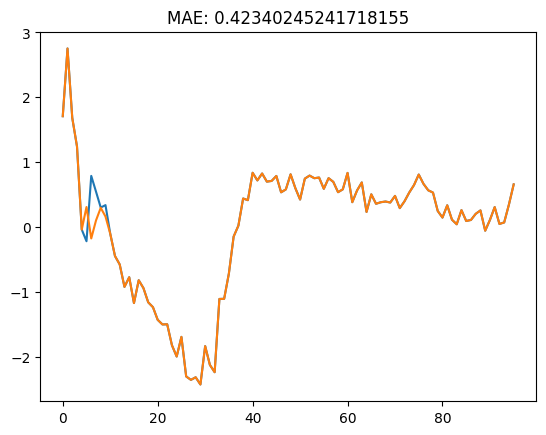

In [91]:
idx = 7
plt.plot(X_test_original[idx])
plt.plot(cdrec_imputed[idx])
err = calc_mae(cdrec_imputed[idx], X_test_original[idx], mask[idx])
plt.title(f"MAE: {err}")